In [1]:
import numpy as np
import os
import scipy
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import itertools
wandb.login()
pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
granularity_palette = sns.color_palette('coolwarm', 2)
local_sps_palette = sns.color_palette("Set2", 3)
cv_palette = sns.color_palette("YlOrRd", 5)
nlp_palette = sns.color_palette("YlGnBu", 3)
cv_nlp_palette = sns.color_palette(["#c90823", "#225da8"], 2)
font_scale = 1.5
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
WANDB_ENTITY = "kubework"
WANDB_PROJECT = "paper-2023"

def get_env(var):
    val = os.getenv(var)
    if val == None:
        raise ValueError(f"Environment variable {var} is not set. Please follow the README.md instructions and start the notebook with all environment variables set.")
    else:
        print(f"{var}:{val}")
    return val

LOG_PATH=get_env("LOG_PATH")
NETWORK_PATH=get_env("NETWORK_LOG_PATH")
FIGURE_PATH=get_env("FIGURE_PATH")

def save_figure(name, local_fig_dir, file_type='pdf'):
    '''Save matplotlib figures at a local directory based on the full hardcoded path
    :param name: str - name of the pdf figure (e.g., "throughput")
    :param local_fig_dir: str - plots are saved under a subdirectory based on the pipeline (e.g., "image-pipeline")
    '''
    figure_path   = FIGURE_PATH
    full_fig_dir  = figure_path + "/" + local_fig_dir
    full_fig_path = full_fig_dir + "/" + name + "." + file_type
    dpi = 300
    plt.savefig(full_fig_path, dpi=dpi, bbox_inches = "tight")
    
def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir="misc", file_type=file_type)

wandb: Currently logged in as: cirquit (kubework). Use `wandb login --relogin` to force relogin


LOG_PATH:../../artifacts/wandb
NETWORK_LOG_PATH:../../artifacts/networking/logs
FIGURE_PATH:../../../vldb-2023-submission/figures


In [14]:
api = wandb.Api()

def get_runs(run_name: str):
    """
    """
    entity = WANDB_ENTITY
    project = WANDB_PROJECT
    path = entity + "/" + project
    key = "config.run_name"
    filters = { key: run_name }
    return api.runs(path=path, filters=filters)

def get_history_non_cached(run, keys):
    history = run.scan_history(keys=keys)
    output = []
    for row in history:
        row_output = {}
        for key in keys:
            row_output[key] = row[key]
        output.append(row_output)
    return pd.DataFrame(output)

def get_history(run, cache=True):
    run_name = run.config.get("run_name")
    host_name = run.config.get("host")
    history_run_path = f"{LOG_PATH}/{run_name}-{host_name}.csv"
    if cache and os.path.isfile(history_run_path):
        return pd.read_csv(history_run_path)
    else:
        history = run.scan_history()
        dataframe_content = []
        for row in history:
            dataframe_content.append(row)
        df = pd.DataFrame(dataframe_content)
        df.to_csv(history_run_path, index=False)
        return df

def get_run_by_prefix(runs, prefix):
    prefixed_runs = []
    for run in runs:
        if run.name.startswith(prefix):
            prefixed_runs.append(run)
    print(f"> Found {len(prefixed_runs)} runs with the prefix '{prefix}'.")
    return prefixed_runs

def get_run_by_infix(runs, infix):
    infixed_runs = []
    for run in runs:
        if infix in run.name:
            infixed_runs.append(run)
    print(f"> Found {len(infixed_runs)} runs with the infix '{infix}'.")
    return infixed_runs

def get_clean_history(run, filter_by="hivemind", cache=True):
    """Tries to fix the two async wandb threads that logged together.
    :filter_by:
        - "hivemind": tries to fix the history
        - "hardware": returns the history without fixing, as we don't need perfect sync here
    """
    history_df = get_history(run, cache=cache)
    if "baseline" in run.config.get("run_name"):
        additional_keys = ['01_general/step_based_sps']
    else:
        additional_keys = ['03_hivemind/num_peers',
                           '03_hivemind/global_epoch']
    if filter_by == "hivemind":
        keys = ['01_general/locally_processed_samples',
                '01_general/lr',
                '01_general/step',
                #'01_general/minibatch_loss', # loss.item() was too often None for NLP baseline, non NaN
                '01_general/dataset_iteration_count',
                '02_timing/dataload_time_s',
                '02_timing/dataload_cuda_move_time_s',
                '02_timing/forward_time_s',
                '02_timing/backward_time_s',
                '02_timing/loss_calc_time_s',
                '02_timing/opt_step_time_s',
                '02_timing/step_time_s',
                '_step',
                '_runtime',
                ] + additional_keys
        filtered_history_df = history_df[keys]
        return merge_rows(df=filtered_history_df, ignore_cols=['_step','_runtime'])
    elif filter_by == "hardware":
        keys = [
            'memory/total_memory_sys_MB',
            'memory/used_memory_sys_MB',
            'memory/available_memory_sys_MB',
            'memory/used_memory_sys_percent',
            'process/memory/virtual_memory_size_proc_MB',
            'process/memory/text_resident_set_proc_MB', 
            'process/memory/shared_memory_proc_MB',
            'process/memory/dirty_pages_proc_count',
            'process/memory/data_resident_set_proc_MB',
            'process/memory/resident_set_size_proc_MB',
            'process/memory/lib_memory_proc_MB',
            'process/voluntary_proc_ctx_switches',
            'process/involuntary_proc_ctx_switches',
            'bandwidth/disk_read_sys_bandwidth_MBs',
            'bandwidth/disk_write_sys_bandwidth_MBs',
            'bandwidth/net_sent_sys_bandwidth_Mbits',
            'bandwidth/net_recv_sys_bandwidth_Mbits',
            'disk/time/disk_busy_time_sys_s',
            'disk/time/disk_write_time_sys_s',
            'disk/time/disk_read_time_sys_s',
            'disk/counter/disk_read_sys_count',
            'disk/counter/disk_write_sys_count',
            'cpu/interrupts/ctx_switches_count',
            'cpu/interrupts/soft_interrupts_count',
            'cpu/logical_core_count',
            'cpu/interrupts/interrupts_count',
            'cpu/load/avg_sys_load_one_min_percent',
            'cpu/load/avg_sys_load_five_min_percent',
            'cpu/load/avg_sys_load_fifteen_min_percent',
            '02_timing/opt_step_time_s',
            '_step',
            '_runtime',
        ]
        return history_df[keys]
    else:
        raise ValueError(f"filter_by: {filter_by} not known.")

def merge_rows(df, ignore_cols):
    """Merges rows with interleaved NaNs.
    rowA = [1,     2, NaN,   4, NaN]
    rowB = [NaN, NaN,   3, NaN,   5]
    => result [1, 2, 3, 4, 5]
    
    :df: pd.DataFrame to be merged
    :ignore_cols: list(), keys in this list are merged by using the max(valA, valB) value, e.g. "_step"
    :returns: pd.DataFrame which is merged
    """
    # 1. Drop all full NaN rows
    temp_df = df.dropna(how="all")
    # 2. Iterate over all the rows by keeping a temp row which is filled successivley
    clean_rows = []
    prev_row = None
    cleaned_row_counter = 0
    for ix, row in temp_df.iterrows():
        row_dict = dict(row)
        # 2.1 If the temporary row is commited, start with the new row
        if prev_row == None:
            # 2.1.1 If the new row has NaN values, set it "to be completed"
            if any_values_are_nan(row_dict):
                prev_row = row_dict
            else:
            # 2.1.2 If the new row is complete, commit it
                clean_rows.append(row_dict)
        # 2.2 If we have a row to be completed, try to fill the values with the next row
        else:
            temp_row = merge_dicts(dictA=prev_row, dictB=row, ignore_cols=ignore_cols)
            # 2.2.1 If there are still NaNs, keep it for next processing
            if any_values_are_nan(temp_row):
                prev_row = temp_row
            # 2.2.2 If no NaNs exist anymore, commit and prepare for next row
            else:
                clean_rows.append(temp_row)
                prev_row = None
    return pd.DataFrame(clean_rows)

def merge_dicts(dictA, dictB, ignore_cols):
    """Merges two dicts together by filling the NaN values.
    If not in :ignore_cols: and both values are non NaN, an exception is thrown.
    Both dicts have the same keys.
    :dictA: dict()
    :dictB: dict()
    :ignore_cols: list(), the value of these keys will be decided by a max(a,b)
    :returns: dict()
    """
    result = {}
    for key in dictA:     
        if key in ignore_cols and \
            not math.isnan(dictA[key]) and \
            not math.isnan(dictB[key]):
            result[key] = max(dictA[key], dictB[key])
        else:
            try:
                result[key] = return_non_nan(dictA[key], dictB[key])
            except ValueError:
                print(f"Values ({dictA[key]}) and ({dictB[key]}) for key ({key}) are neither NaN, picking max.")
                result[key] = max(dictA[key], dictB[key])
    return result

def any_values_are_nan(dictionary):
    """
    """
    return any([math.isnan(dictionary[key]) for key in dictionary])
        
def return_non_nan(a, b):
    if math.isnan(a) and math.isnan(b):
        return a
    if math.isnan(a) and not math.isnan(b):
        return b
    if not math.isnan(a) and math.isnan(b):
        return a
    if not math.isnan(a) and not math.isnan(b):
        raise ValueError(f"Tuple (a,b) of ({a}, {b}) are neither NaN.")

def round_bar_value_multi(ax, decimals=2):
    for containers in ax.containers:
        for container in containers:
            container.set_height(round(container.get_height(), decimals))
        ax.bar_label(containers)
        
def set_fontsizes(small=8, medium=10, bigger=12):
    SMALL_SIZE = small
    MEDIUM_SIZE = medium
    BIGGER_SIZE = bigger

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    plt.rcParams['legend.title_fontsize'] = MEDIUM_SIZE

In [3]:
def get_baseline_runs(run_names, keys=["01_general/step_based_sps"]):
    baseline_runs = [get_runs(run_name=run_name)[0] for run_name in run_names]
    baseline_dfs = []
    for run in baseline_runs:
        baseline_df = get_clean_history(run = run, filter_by="hivemind")
        baseline_df = baseline_df[keys]
        baseline_df["name"] = "-".join(run.config.get("run_name").split(".")[0].split("-")[:2])
        if "torchvision" in run.config.get("run_name"):
            baseline_df["model"] = run.config.get("run_name").split(".")[-1]
        if "roberta" in run.config.get("run_name"):
            baseline_df["model"] = run.config.get("run_name").split("-")[-1]
        baseline_df["TBS"] = run.config.get("batch_size_per_step") * run.config.get("gradient_accumulation_steps")
        baseline_df = baseline_df.rename(columns={"01_general/step_based_sps": "samples_per_sec"})
        baseline_dfs.append(baseline_df)
    return pd.concat(objs=baseline_dfs)

def get_hivemind_runs(run_names, drop_first_epoch=True):
    
    hivemind_176_add = False
    # adding manually as W&B API does not see this run because it was deleted and restored
    if "hivemind-176" in run_names:
        run_names.remove("hivemind-176")
        hivemind_176_add = True
        
    hivemind_runs = [get_run_by_prefix(
                        runs = get_runs(run_name = run_name),
                        prefix = "trainmonitor")[0]
                     for run_name in run_names]
    if hivemind_176_add:
        # trainmonitor-176
        hivemind_runs.append(api.run(path="kubework/paper-2023/1e4zlzpd"))
    hivemind_dfs = []
    
    keys = ["03_hivemind/optimistic_total_samples_per_second",
            "03_hivemind/epoch_based_sps"]
    
    for run in hivemind_runs:
        hivemind_df = get_history(run = run)
        hivemind_df = hivemind_df[keys]
        hivemind_df["name"] = run.config.get("run_name")
        hivemind_df["model"] = run.config.get("model").split(".")[-1]
        hivemind_df["TBS"] = run.config.get("target_batch_size")
        hivemind_df = hivemind_df.rename(columns={"03_hivemind/epoch_based_sps": "samples_per_sec"})
        hivemind_df = hivemind_df.rename(columns={"03_hivemind/optimistic_total_samples_per_second": "local samples_per_sec"})
        if drop_first_epoch:
            # get index of the first epoch value
            first_index = hivemind_df.query("samples_per_sec.notna()").index[0]
            # get index of last epoch value
            last_index = hivemind_df.query("samples_per_sec.notna()").index[-1]
            # start the dataframe from the next value
            hivemind_df = hivemind_df[first_index+1:last_index+1]
        hivemind_dfs.append(hivemind_df)
    return pd.concat(objs=hivemind_dfs)

def rename_models(df):
    df = df.replace("resnet18", "ResNet18")
    df = df.replace("resnet50", "ResNet50")
    df = df.replace("resnet152", "ResNet152")
    df = df.replace("wide_resnet101_2", "WideResNet101_2")
    df = df.replace("convnext_large", "ConvNextLarge")
    df = df.replace("roberta_mlm_base", "RoBERTaBase")
    df = df.replace("roberta_mlm_large", "RoBERTaLarge")
    df = df.replace("roberta_mlm_xlm", "RoBERTaXLM")
    return df

def compute_local_step_cutoff(df, debug=False):
    """We get a unimodal time series with 3 outliers (sync steps)
    Returning a cutoff where all of the outliers are included.
    """
    median = df.median()
    std = df.std()
    cutoff = median + 2*std # 95% of all data should be included here
    if debug:
        print(f">> Found {len(df.index[df >= cutoff].tolist())} sync steps: {df[df >= cutoff].tolist()}")
    return cutoff

def get_aggregated_step_timings(df, agg = "sum", clean = True, debug = False):
    
    # 02_timing/dataload_time_s - unimodal with one startup outlier
    # 02_timing/dataload_cuda_move_time_s - unimodal
    # 02_timing/forward_time_s - unimodal
    # 02_timing/loss_calc_time_s - unimodal
    # 02_timing/backward_time_s - unimodal
    # 02_timing/opt_step_time_s - bi/tri-modal
    # 02_timing/step_time_s - bi/tri-modal
    
    agg_dict = {}
    # opt_step_time_data.plot.hist()    
    # opt.step() is basically a no-op
    
    # detect the outliers (sync-steps) and decide on a cutoff
    # which includes all of them (the fastest sync step)
    NON_LOCAL_STEP_CUTOFF_S = compute_local_step_cutoff(df["02_timing/opt_step_time_s"], debug=debug)
        
    # exclude the first hivemind epoch from logging
    if clean:
        averaging_ix = df.index[df["02_timing/opt_step_time_s"] >= NON_LOCAL_STEP_CUTOFF_S].tolist()
        #assert(len(averaging_ix) >= 2), f"At least 2x averaging indices should be included: {averaging_ix}"
        first_averaging_ix = averaging_ix[0] + 1 # starting from the next step
        cleaned_df = df[first_averaging_ix:]
    else:
        cleaned_df = df
    
    opt_step_time_data = cleaned_df["02_timing/opt_step_time_s"]
    
    if agg == "sum":
        agg_dict["dataload_s"] = cleaned_df["02_timing/dataload_time_s"].sum()
        agg_dict["cuda_move_s"] = cleaned_df["02_timing/dataload_cuda_move_time_s"].sum()
        agg_dict["forward_s"] = cleaned_df["02_timing/forward_time_s"].sum()
        agg_dict["loss_calc_s"] = cleaned_df["02_timing/loss_calc_time_s"].sum()
        agg_dict["backward_s"] = cleaned_df["02_timing/backward_time_s"].sum()
        agg_dict["opt_step_local_s"] = opt_step_time_data[opt_step_time_data < NON_LOCAL_STEP_CUTOFF_S].sum()
        agg_dict["opt_step_sync_s"] = opt_step_time_data[opt_step_time_data >= NON_LOCAL_STEP_CUTOFF_S].sum()
    elif agg == "mean":
        agg_dict["dataload_s"] = cleaned_df["02_timing/dataload_time_s"].mean()
        agg_dict["cuda_move_s"] = cleaned_df["02_timing/dataload_cuda_move_time_s"].mean()
        agg_dict["forward_s"] = cleaned_df["02_timing/forward_time_s"].mean()
        agg_dict["loss_calc_s"] = cleaned_df["02_timing/loss_calc_time_s"].mean()
        agg_dict["backward_s"] = cleaned_df["02_timing/backward_time_s"].mean()
        agg_dict["opt_step_local_s"] = opt_step_time_data[opt_step_time_data < NON_LOCAL_STEP_CUTOFF_S].mean()
        agg_dict["opt_step_sync_s"] = opt_step_time_data[opt_step_time_data >= NON_LOCAL_STEP_CUTOFF_S].mean()
         
    # wrap in lists for pandas df creation
    for key in agg_dict.keys(): agg_dict[key] = [agg_dict[key]]
    
    return pd.DataFrame(agg_dict)

def hivemind_run_step_breakdown(run_name: str, agg = "sum", debug=False):
    # filter all runs by workers
    hivemind_runs = get_run_by_infix(
        runs = get_runs(run_name = run_name),
        infix = "bee")
    
    aggregated_dfs = []
    
    # aggregate gpu runs
    for gpu_run in hivemind_runs:
        gpu_agg_df = get_aggregated_step_timings(
            df=get_clean_history(
                run=gpu_run, filter_by="hivemind"),
            agg=agg,
            debug=debug)
        gpu_agg_df["name"] = gpu_run.config.get("host")
        aggregated_dfs.append(gpu_agg_df)
    
    return pd.concat(objs=aggregated_dfs)

def hivemind_run_step_breakdown_concatenated(run_name: str, debug=False):
    # filter all runs by workers
    hivemind_runs = get_run_by_infix(
        runs = get_runs(run_name = run_name),
        infix = "bee")
    
    timing_keys = [
        "02_timing/dataload_time_s",
        "02_timing/dataload_cuda_move_time_s",
        "02_timing/forward_time_s",
        "02_timing/backward_time_s",
        "02_timing/loss_calc_time_s",
        "02_timing/opt_step_time_s",
        "name"
    ]
    
    non_sync_list = []
    sync_list = []
    
    # aggregate gpu runs
    for gpu_run in hivemind_runs:
        
        gpu_run_df = get_clean_history(run=gpu_run, filter_by="hivemind")
        NON_LOCAL_STEP_CUTOFF_S = compute_local_step_cutoff(gpu_run_df["02_timing/opt_step_time_s"], debug=debug)
        print(NON_LOCAL_STEP_CUTOFF_S)
        averaging_ix = gpu_run_df.index[gpu_run_df["02_timing/opt_step_time_s"] >= NON_LOCAL_STEP_CUTOFF_S].tolist()
        print(averaging_ix)
        non_sync_df = gpu_run_df.drop(index=averaging_ix)
        non_sync_df["name"] = gpu_run.config.get("host")
        
        sync_df = gpu_run_df.iloc[averaging_ix] 
        
        sync_df["name"] = gpu_run.config.get("host")
        
        non_sync_list.append(non_sync_df[timing_keys])
        sync_list.append(sync_df[timing_keys])
    
    full_non_sync_df = pd.concat(objs=non_sync_list)
    full_non_sync_df = full_non_sync_df.reset_index(drop=True)
    full_sync_df = pd.concat(objs=sync_list)
    full_sync_df = full_sync_df.reset_index(drop=True)
    return full_non_sync_df, full_sync_df

def get_peak_bandwidths(run_name, val_dict):
    
    print_median_recv_bandwidth(run_name = run_name)
    hivemind_runs = get_run_by_infix(
            runs = get_runs(run_name = run_name),
            infix = "bee")

    run_list = []
    
    for run in hivemind_runs:
        df = get_clean_history(run=run, filter_by="hardware")
        
        debug = False
        NON_LOCAL_STEP_CUTOFF_S = compute_local_step_cutoff(df["02_timing/opt_step_time_s"], debug=debug)
        averaging_ix = df.index[df["02_timing/opt_step_time_s"] >= NON_LOCAL_STEP_CUTOFF_S].tolist()

        agg_dict = {
            "peak_sent_Mbits": [],
            "peak_recv_Mbits": [],
            "sync_time_s": [],
            "ix": [],
        }
        
        # get the averaging index, count seconds back based on averaging time
        # take that window and get the maximum bandwidths
        for ix in averaging_ix:
            averaging_step_df = df.iloc[ix]
            averaging_step_time_s = averaging_step_df["02_timing/opt_step_time_s"]
            rounded_averaging_step_time_s = math.ceil(averaging_step_time_s)
            window_averaging_df = df.iloc[ix - rounded_averaging_step_time_s: ix]
            max_sent_Mbits = window_averaging_df["bandwidth/net_sent_sys_bandwidth_Mbits"].max()
            max_recv_Mbits = window_averaging_df["bandwidth/net_recv_sys_bandwidth_Mbits"].max()
            agg_dict["peak_sent_Mbits"].append(max_sent_Mbits)
            agg_dict["peak_recv_Mbits"].append(max_recv_Mbits)
            agg_dict["sync_time_s"].append(averaging_step_time_s)
            agg_dict["ix"].append(ix)

        agg_df = pd.DataFrame(agg_dict)
        agg_df["name"] = run.config.get("host")
        run_list.append(agg_df)

    all_runs_df = pd.concat(objs=run_list)
    all_runs_df = all_runs_df.reset_index(drop=True)
    
    for key, val in val_dict.items():
        all_runs_df[key] = val
    return all_runs_df

def print_median_recv_bandwidth(run_name):
    hivemind_runs = get_run_by_infix(
            runs = get_runs(run_name = run_name),
            infix = "bee")
    median_list = []
    for run in hivemind_runs:
        df = get_clean_history(run=run, filter_by="hardware")
        run_median = df["bandwidth/net_recv_sys_bandwidth_Mbits"].median()
        median_list.append(run_median)
    print(f"Median received network rate for {run_name}: {round(sum(median_list) / len(median_list),2)}MBits")

# Cloud Experiments

In [4]:
cloud_cv_US_2xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-81", val_dict={"domain":"CV", "gpu_count": 2, "type": "US T4", "model": "ConvNextLarge", "TBS": 32768})
cloud_cv_US_3xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-354", val_dict={"domain":"CV", "gpu_count": 3, "type": "US T4", "model": "ConvNextLarge", "TBS": 32768})
cloud_cv_US_4xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-77", val_dict={"domain":"CV", "gpu_count": 4, "type": "US T4", "model": "ConvNextLarge", "TBS": 32768})
cloud_cv_US_6xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-114", val_dict={"domain":"CV", "gpu_count": 6, "type": "US T4", "model": "ConvNextLarge", "TBS": 32768})
cloud_cv_US_8xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-79", val_dict={"domain":"CV", "gpu_count": 8, "type": "US T4", "model": "ConvNextLarge", "TBS": 32768})

cloud_cv_US_T4_bandwidths_df = pd.concat(objs=[
    cloud_cv_US_2xT4_bandwidths_df,
    cloud_cv_US_3xT4_bandwidths_df,
    cloud_cv_US_4xT4_bandwidths_df,
    cloud_cv_US_6xT4_bandwidths_df,
    cloud_cv_US_8xT4_bandwidths_df
])
cloud_cv_US_T4_bandwidths_df = cloud_cv_US_T4_bandwidths_df.reset_index(drop=True)

cloud_nlp_US_2xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-82", val_dict={"domain":"NLP", "gpu_count": 2, "type": "US T4", "model": "RoBERTaXLM", "TBS": 32768})
cloud_nlp_US_3xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-355", val_dict={"domain":"NLP", "gpu_count": 3, "type": "US T4", "model": "RoBERTaXLM", "TBS": 32768})
cloud_nlp_US_4xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-78", val_dict={"domain":"NLP", "gpu_count": 4, "type": "US T4", "model": "RoBERTaXLM", "TBS": 32768})
cloud_nlp_US_6xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-115", val_dict={"domain":"NLP", "gpu_count": 6, "type": "US T4", "model": "RoBERTaXLM", "TBS": 32768})
cloud_nlp_US_8xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-80", val_dict={"domain":"NLP", "gpu_count": 8, "type": "US T4", "model": "RoBERTaXLM", "TBS": 32768})

cloud_nlp_US_T4_bandwidths_df = pd.concat(objs=[
    cloud_nlp_US_2xT4_bandwidths_df,
    cloud_nlp_US_3xT4_bandwidths_df,
    cloud_nlp_US_4xT4_bandwidths_df,
    cloud_nlp_US_6xT4_bandwidths_df,
    cloud_nlp_US_8xT4_bandwidths_df
])
cloud_nlp_US_T4_bandwidths_df = cloud_nlp_US_T4_bandwidths_df.reset_index(drop=True)

> Found 2 runs with the infix 'bee'.
Median received network rate for hivemind-81: 31.59MBits
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
Median received network rate for hivemind-354: 31.56MBits
> Found 3 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
Median received network rate for hivemind-77: 32.4MBits
> Found 4 runs with the infix 'bee'.
> Found 6 runs with the infix 'bee'.
Median received network rate for hivemind-114: 32.88MBits
> Found 6 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
Median received network rate for hivemind-79: 32.97MBits
> Found 8 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
Median received network rate for hivemind-82: 22.4MBits
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
Median received network rate for hivemind-355: 25.5MBits
> Found 3 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
Median received network rate for hivemind-78: 

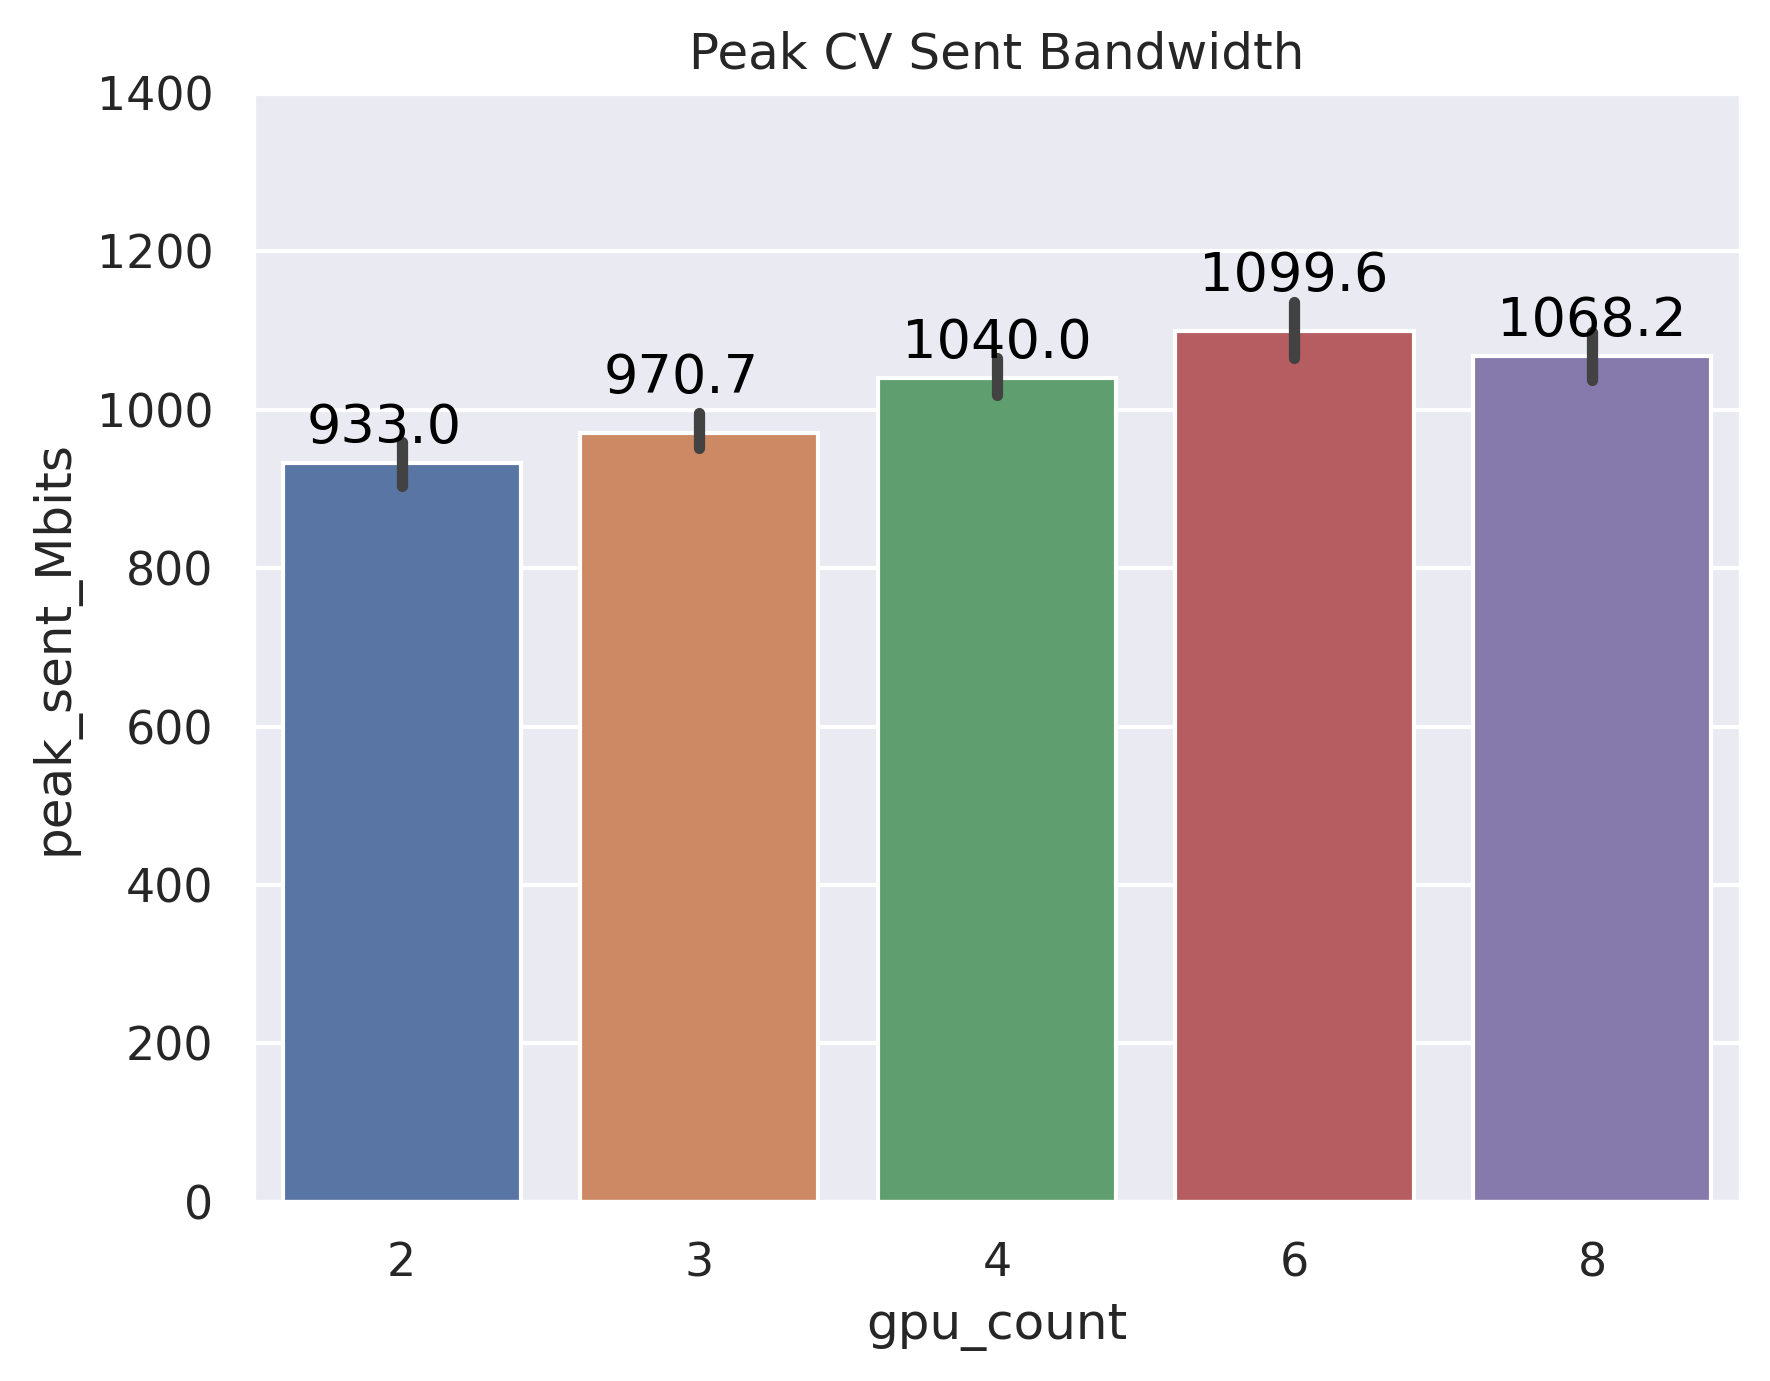

In [5]:
ax = sns.barplot(
    data = cloud_cv_US_T4_bandwidths_df,
    x = "gpu_count",
    y = "peak_sent_Mbits",
)
plt.title("Peak CV Sent Bandwidth")
plt.ylim(0, 1400)
show_values_on_barplot(ax, height=25, rotation=0, decimals=1, fontsize=13)

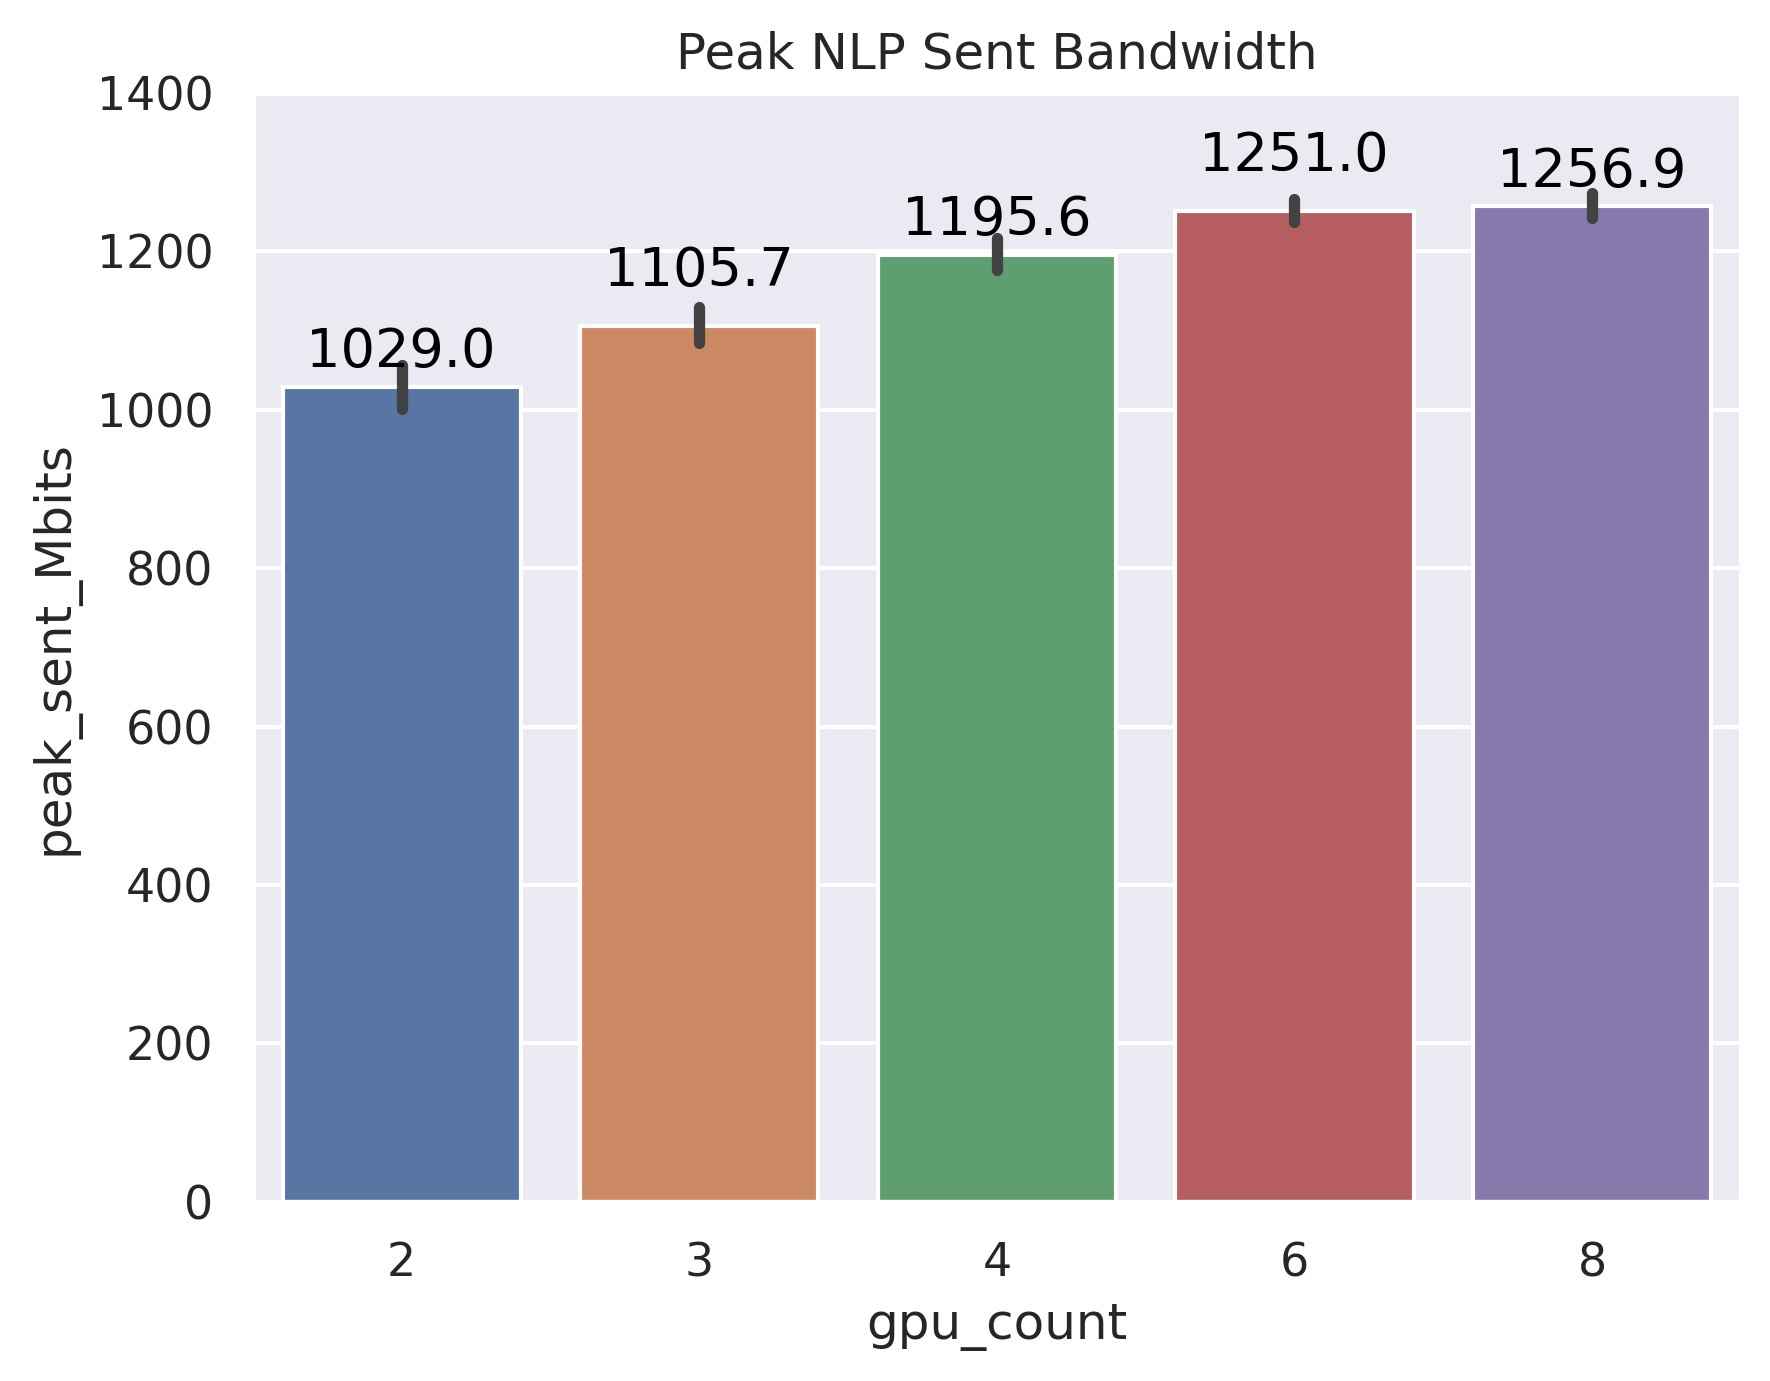

In [6]:
ax = sns.barplot(
    data = cloud_nlp_US_T4_bandwidths_df,
    x = "gpu_count",
    y = "peak_sent_Mbits",
)
plt.title("Peak NLP Sent Bandwidth")
plt.ylim(0, 1400)
show_values_on_barplot(ax, height=25, rotation=0, decimals=1, fontsize=13)

# EU + US Cloud

In [5]:
cloud_cv_US_EU_2xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-348", val_dict={"domain":"CV", "gpu_count": 2, "type": "US + EU T4", "model": "ConvNextLarge", "TBS": 32768})
cloud_cv_US_EU_4xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-83", val_dict={"domain":"CV", "gpu_count": 4, "type": "US + EU T4", "model": "ConvNextLarge", "TBS": 32768})
cloud_cv_US_EU_6xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-85", val_dict={"domain":"CV", "gpu_count": 6, "type": "US + EU T4", "model": "ConvNextLarge", "TBS": 32768})
cloud_cv_US_EU_8xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-87", val_dict={"domain":"CV", "gpu_count": 8, "type": "US + EU T4", "model": "ConvNextLarge", "TBS": 32768})

cloud_cv_US_EU_T4_bandwidths_df = pd.concat(objs=[
    cloud_cv_US_EU_2xT4_bandwidths_df,
    cloud_cv_US_EU_4xT4_bandwidths_df,
    cloud_cv_US_EU_6xT4_bandwidths_df,
    cloud_cv_US_EU_8xT4_bandwidths_df
])
cloud_cv_US_EU_T4_bandwidths_df = cloud_cv_US_EU_T4_bandwidths_df.reset_index(drop=True)

cloud_nlp_US_EU_2xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-349", val_dict={"domain":"NLP", "gpu_count": 2, "type": "US + EU T4", "model": "RoBERTaXLM", "TBS": 32768})
cloud_nlp_US_EU_4xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-84", val_dict={"domain":"NLP", "gpu_count": 4, "type": "US + EU T4", "model": "RoBERTaXLM", "TBS": 32768})
cloud_nlp_US_EU_6xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-86", val_dict={"domain":"NLP", "gpu_count": 6, "type": "US + EU T4", "model": "RoBERTaXLM", "TBS": 32768})
cloud_nlp_US_EU_8xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-88", val_dict={"domain":"NLP", "gpu_count": 8, "type": "US + EU T4", "model": "RoBERTaXLM", "TBS": 32768})

cloud_nlp_US_EU_T4_bandwidths_df = pd.concat(objs=[
    cloud_nlp_US_EU_2xT4_bandwidths_df,
    cloud_nlp_US_EU_4xT4_bandwidths_df,
    cloud_nlp_US_EU_6xT4_bandwidths_df,
    cloud_nlp_US_EU_8xT4_bandwidths_df
])
cloud_nlp_US_EU_T4_bandwidths_df = cloud_nlp_US_EU_T4_bandwidths_df.reset_index(drop=True)

> Found 2 runs with the infix 'bee'.
Median received network rate for hivemind-348: 31.97MBits
> Found 2 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
Median received network rate for hivemind-83: 32.64MBits
> Found 4 runs with the infix 'bee'.
> Found 6 runs with the infix 'bee'.
Median received network rate for hivemind-85: 32.91MBits
> Found 6 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
Median received network rate for hivemind-87: 33.18MBits
> Found 8 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
Median received network rate for hivemind-349: 23.38MBits
> Found 2 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
Median received network rate for hivemind-84: 27.89MBits
> Found 4 runs with the infix 'bee'.
> Found 6 runs with the infix 'bee'.
Median received network rate for hivemind-86: 30.18MBits
> Found 6 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
Median received network rate for hivemind-88

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


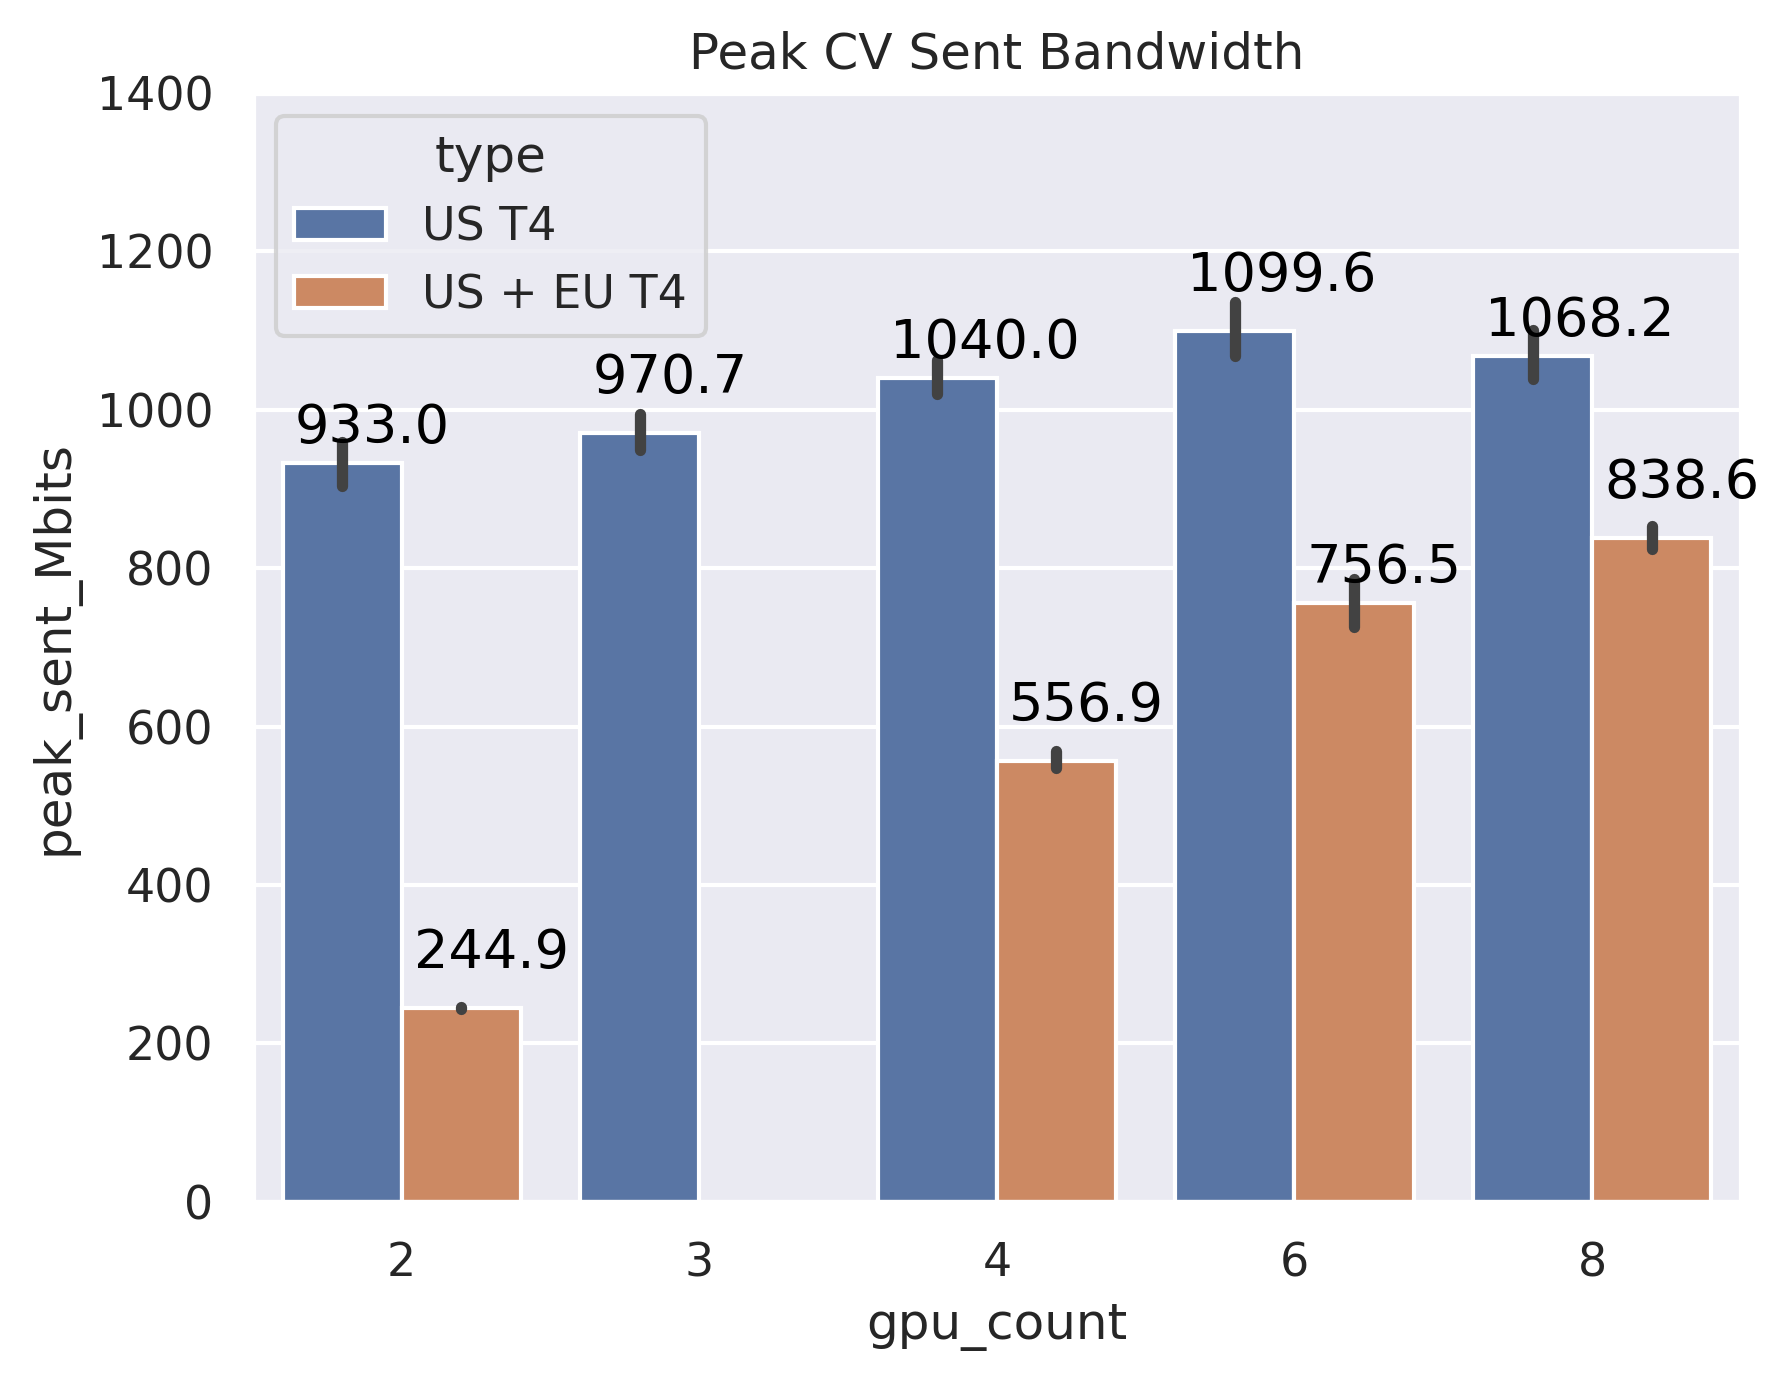

In [8]:
temp_df = pd.concat(objs=[cloud_cv_US_T4_bandwidths_df, cloud_cv_US_EU_T4_bandwidths_df])
ax = sns.barplot(
    data = temp_df,
    x = "gpu_count",
    y = "peak_sent_Mbits",
    hue = "type"
)
plt.title("Peak CV Sent Bandwidth")
plt.ylim(0, 1400)
show_values_on_barplot(ax, height=25, rotation=0, decimals=1, fontsize=13)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


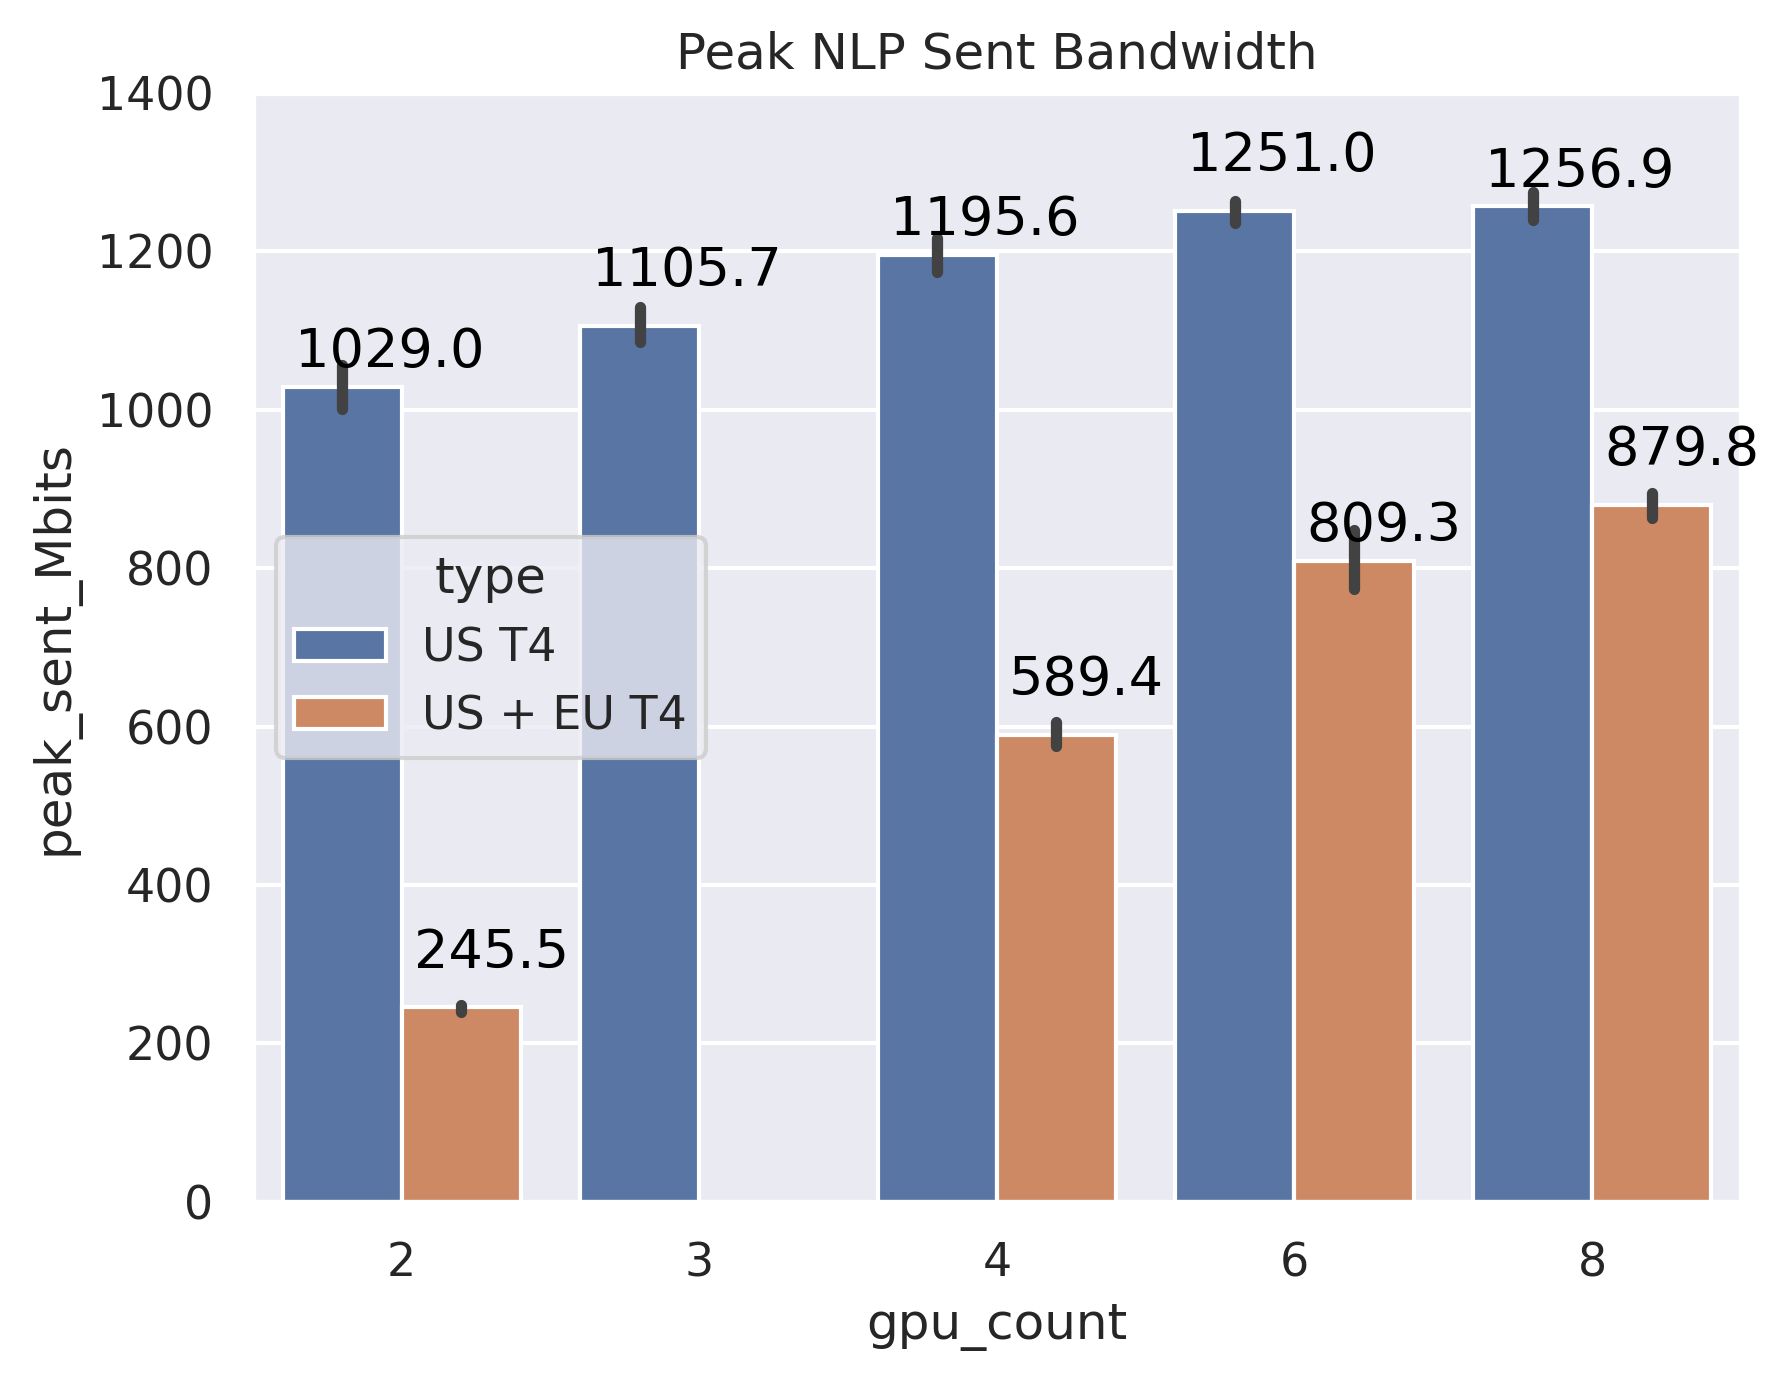

In [9]:
temp_df = pd.concat(objs=[cloud_nlp_US_T4_bandwidths_df, cloud_nlp_US_EU_T4_bandwidths_df])
ax = sns.barplot(
    data = temp_df,
    x = "gpu_count",
    y = "peak_sent_Mbits",
    hue = "type"
)
plt.title("Peak NLP Sent Bandwidth")
plt.ylim(0, 1400)
show_values_on_barplot(ax, height=25, rotation=0, decimals=1, fontsize=13)

## (C) Inter-continental

In [6]:
cloud_cv_US_EU_ASIA_3xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-350", val_dict={"domain":"CV", "gpu_count": 3, "type": "US + EU + ASIA T4", "model": "ConvNextLarge", "TBS": 32768})
cloud_cv_US_EU_ASIA_AUS_4xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-352", val_dict={"domain":"CV", "gpu_count": 4, "type": "US + EU + ASIA + AUS T4", "model": "ConvNextLarge", "TBS": 32768})
cloud_cv_US_EU_ASIA_6xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-89", val_dict={"domain":"CV", "gpu_count": 6, "type": "US + EU + ASIA T4", "model": "ConvNextLarge", "TBS": 32768})
cloud_cv_US_EU_ASIA_AUS_8xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-92", val_dict={"domain":"CV", "gpu_count": 8, "type": "US + EU + ASIA + AUS T4", "model": "ConvNextLarge", "TBS": 32768})

#cloud_cv_US_EU_ASIA_AUS_T4_bandwidths_df = pd.concat(objs=[
#    cloud_cv_US_EU_ASIA_6xT4_bandwidths_df,
#    cloud_cv_US_EU_ASIA_AUS_8xT4_bandwidths_df
#])
#cloud_cv_US_EU_ASIA_AUS_T4_bandwidths_df = cloud_cv_US_EU_ASIA_AUS_T4_bandwidths_df.reset_index(drop=True)

cloud_nlp_US_EU_ASIA_3xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-351", val_dict={"domain":"NLP", "gpu_count": 3, "type": "US + EU + ASIA T4", "model": "RoBERTaXLM", "TBS": 32768})
cloud_nlp_US_EU_ASIA_AUS_4xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-353", val_dict={"domain":"NLP", "gpu_count": 4, "type": "US + EU + ASIA + AUS T4", "model": "RoBERTaXLM", "TBS": 32768})
cloud_nlp_US_EU_ASIA_6xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-90", val_dict={"domain":"NLP", "gpu_count": 6, "type": "US + EU + ASIA T4", "model": "RoBERTaXLM", "TBS": 32768})
cloud_nlp_US_EU_ASIA_AUS_8xT4_bandwidths_df = get_peak_bandwidths(run_name="hivemind-93", val_dict={"domain":"NLP", "gpu_count": 8, "type": "US + EU + ASIA + AUS T4", "model": "RoBERTaXLM", "TBS": 32768})

#cloud_nlp_US_EU_ASIA_AUS_T4_bandwidths_df = pd.concat(objs=[
#    cloud_nlp_US_EU_ASIA_6xT4_bandwidths_df,
#    cloud_nlp_US_EU_ASIA_AUS_8xT4_bandwidths_df
#])
#cloud_nlp_US_EU_ASIA_AUS_T4_bandwidths_df = cloud_nlp_US_EU_ASIA_AUS_T4_bandwidths_df.reset_index(drop=True)

> Found 3 runs with the infix 'bee'.
Median received network rate for hivemind-350: 33.01MBits
> Found 3 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
Median received network rate for hivemind-352: 33.73MBits
> Found 4 runs with the infix 'bee'.
> Found 6 runs with the infix 'bee'.
Median received network rate for hivemind-89: 33.49MBits
> Found 6 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
Median received network rate for hivemind-92: 34.01MBits
> Found 8 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
Median received network rate for hivemind-351: 28.45MBits
> Found 3 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
Median received network rate for hivemind-353: 32.8MBits
> Found 4 runs with the infix 'bee'.
> Found 6 runs with the infix 'bee'.
Median received network rate for hivemind-90: 34.19MBits
> Found 6 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
Median received network rate for hivemind-9

In [11]:
display(cloud_nlp_US_EU_ASIA_3xT4_bandwidths_df)
display(cloud_cv_US_EU_ASIA_AUS_4xT4_bandwidths_df)

,peak_sent_Mbits,peak_recv_Mbits,sync_time_s,ix,name,domain,gpu_count,type,model,TBS
0,247.993404,258.478940,71.263164,462,gc-t4-3,NLP,3,US + EU + ASIA T4,RoBERTaXLM,32768
1,255.203422,249.292695,73.819674,976,gc-t4-3,NLP,3,US + EU + ASIA T4,RoBERTaXLM,32768
2,270.810871,240.553319,73.338759,1489,gc-t4-3,NLP,3,US + EU + ASIA T4,RoBERTaXLM,32768
3,253.320890,295.237794,71.715389,517,gc-t4-2,NLP,3,US + EU + ASIA T4,RoBERTaXLM,32768
4,271.787383,261.474038,74.655732,1024,gc-t4-2,NLP,3,US + EU + ASIA T4,RoBERTaXLM,32768
5,277.766373,288.940988,73.707233,1533,gc-t4-2,NLP,3,US + EU + ASIA T4,RoBERTaXLM,32768
6,287.091990,308.810708,71.505841,665,gc-t4-1,NLP,3,US + EU + ASIA T4,RoBERTaXLM,32768
7,295.256300,355.196627,74.626308,1174,gc-t4-1,NLP,3,US + EU + ASIA T4,RoBERTaXLM,32768
8,291.388542,327.693174,73.600951,1680,gc-t4-1,NLP,3,US + EU + ASIA T4,RoBERTaXLM,32768


,peak_sent_Mbits,peak_recv_Mbits,sync_time_s,ix,name,domain,gpu_count,type,model,TBS
0,266.399832,313.383772,28.328047,497,gc-t4-4,CV,4,US + EU + ASIA + AUS T4,ConvNextLarge,32768
1,276.849960,289.590372,28.203917,1012,gc-t4-4,CV,4,US + EU + ASIA + AUS T4,ConvNextLarge,32768
2,295.865801,305.070341,27.711869,1526,gc-t4-4,CV,4,US + EU + ASIA + AUS T4,ConvNextLarge,32768
3,316.569577,328.054042,28.703260,498,gc-t4-3,CV,4,US + EU + ASIA + AUS T4,ConvNextLarge,32768
4,325.407354,355.362516,28.533480,1007,gc-t4-3,CV,4,US + EU + ASIA + AUS T4,ConvNextLarge,32768
5,305.126600,290.480686,27.658199,1515,gc-t4-3,CV,4,US + EU + ASIA + AUS T4,ConvNextLarge,32768
6,347.691181,351.283537,28.644153,520,gc-t4-2,CV,4,US + EU + ASIA + AUS T4,ConvNextLarge,32768
7,298.596694,308.780481,28.160081,1033,gc-t4-2,CV,4,US + EU + ASIA + AUS T4,ConvNextLarge,32768
8,294.360024,278.552081,27.200205,1545,gc-t4-2,CV,4,US + EU + ASIA + AUS T4,ConvNextLarge,32768
9,377.316224,387.092401,28.741245,623,gc-t4-1,CV,4,US + EU + ASIA + AUS T4,ConvNextLarge,32768


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


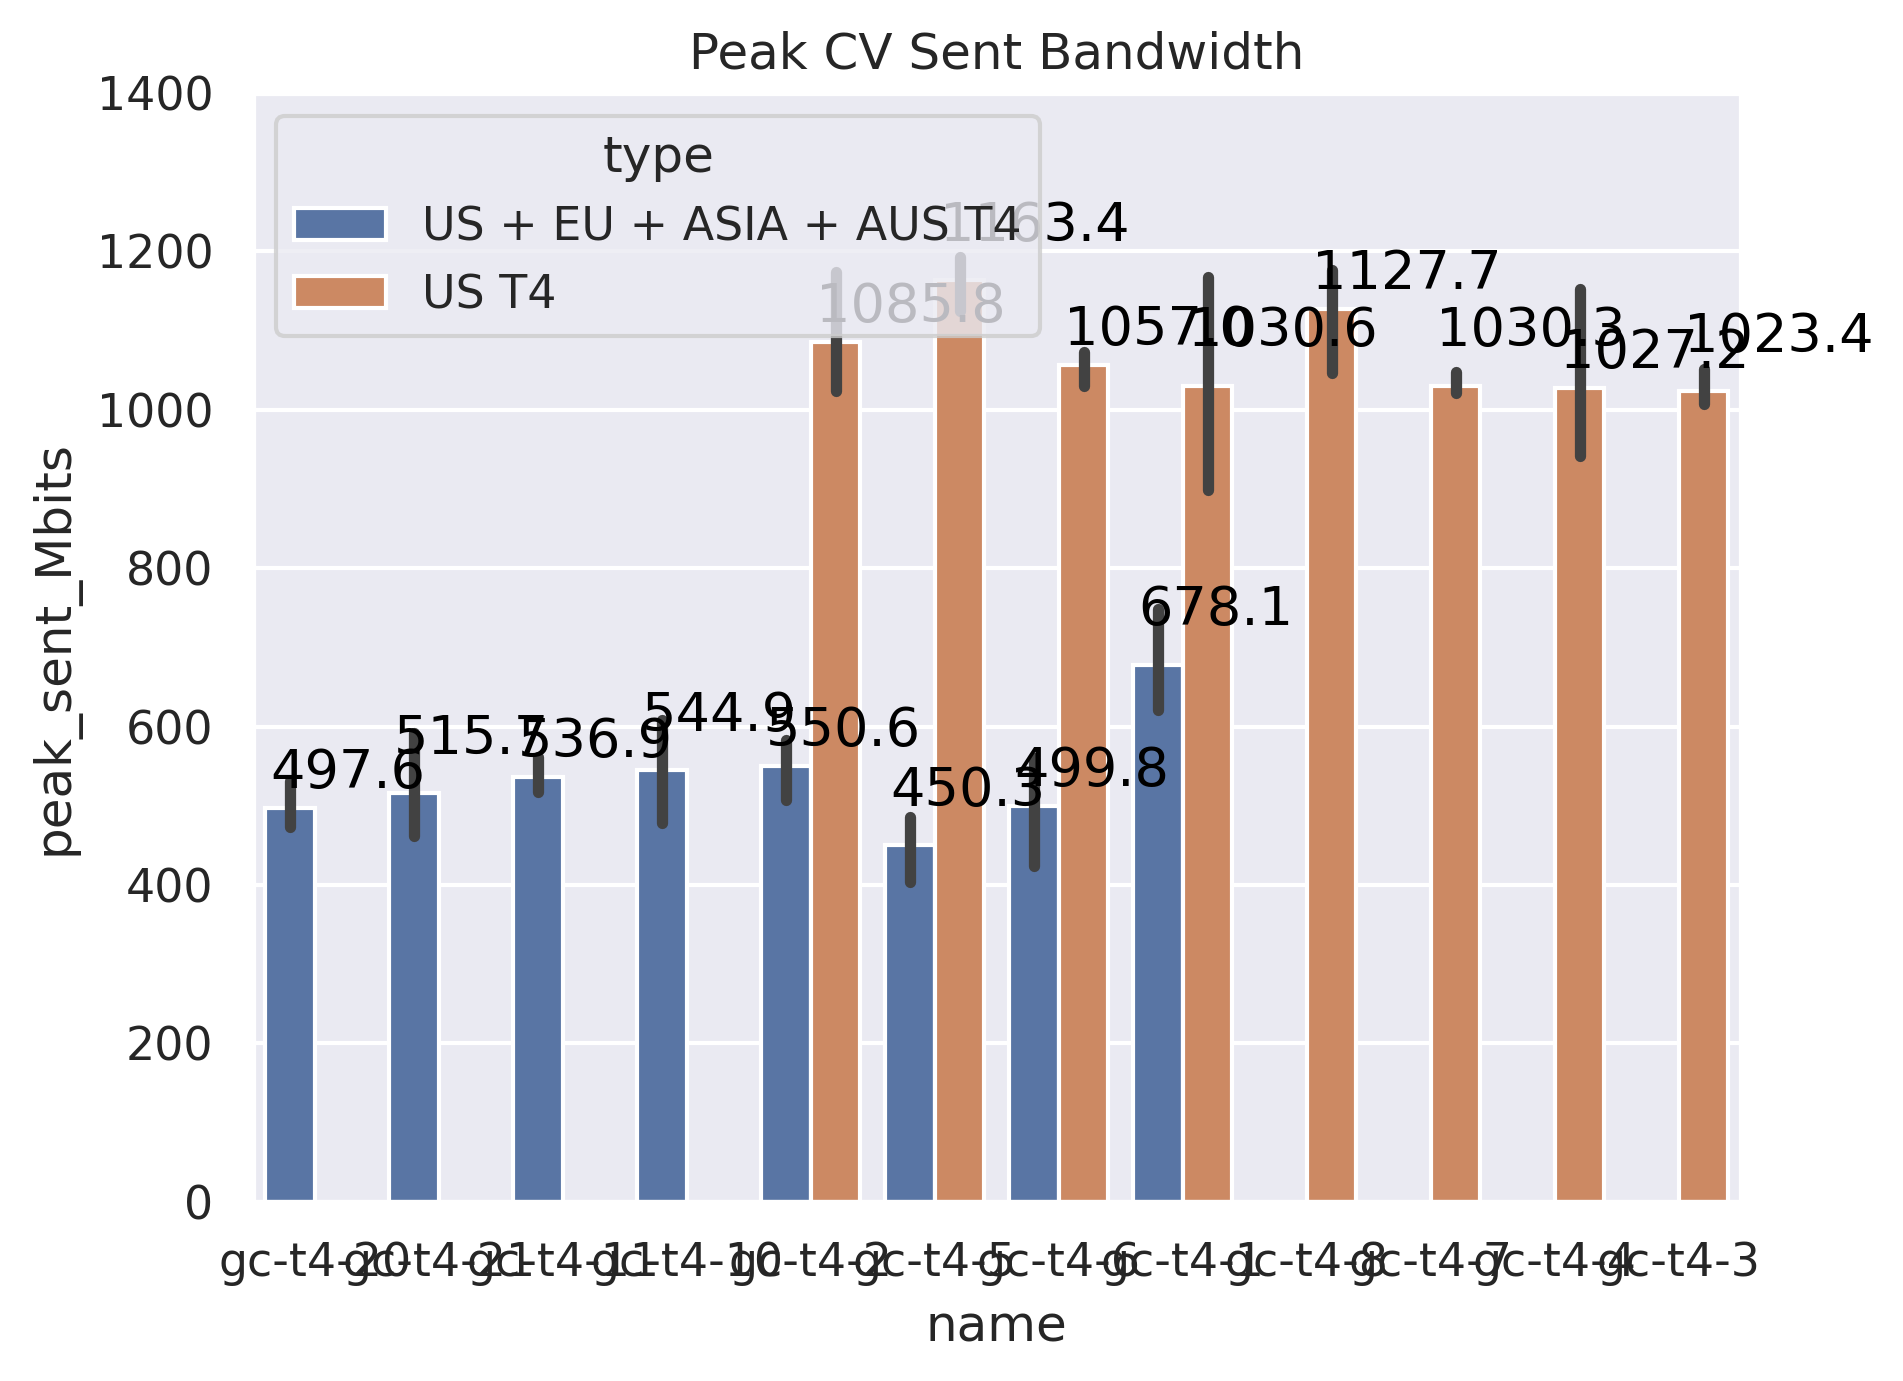

In [12]:
#temp_df = pd.concat(objs=[cloud_nlp_US_EU_ASIA_3xT4_bandwidths_df, cloud_nlp_US_3xT4_bandwidths_df])
#temp_df = pd.concat(objs=[cloud_cv_US_EU_ASIA_3xT4_bandwidths_df, cloud_cv_US_3xT4_bandwidths_df])
#temp_df = pd.concat(objs=[cloud_cv_US_EU_ASIA_AUS_4xT4_bandwidths_df, cloud_cv_US_4xT4_bandwidths_df])
#temp_df = pd.concat(objs=[cloud_nlp_US_EU_ASIA_AUS_4xT4_bandwidths_df, cloud_nlp_US_4xT4_bandwidths_df]) 
temp_df = pd.concat(objs=[cloud_cv_US_EU_ASIA_AUS_8xT4_bandwidths_df, cloud_cv_US_8xT4_bandwidths_df]) 

ax = sns.barplot(
    data = temp_df,
    x = "name",
    y = "peak_sent_Mbits",
    hue = "type"
)
plt.title("Peak CV Sent Bandwidth")
plt.ylim(0, 1400)
show_values_on_barplot(ax, height=25, rotation=0, decimals=1, fontsize=13)

# A10

In [7]:
cv_US_2xA10_bandwidths_df = get_peak_bandwidths(run_name="hivemind-296", val_dict={"domain":"CV", "gpu_count": 2, "type": "US A10", "model": "ConvNextLarge", "TBS": 32768})
cv_US_4xA10_bandwidths_df = get_peak_bandwidths(run_name="hivemind-319", val_dict={"domain":"CV", "gpu_count": 4, "type": "US A10", "model": "ConvNextLarge", "TBS": 32768})
cv_US_8xA10_bandwidths_df = get_peak_bandwidths(run_name="hivemind-330", val_dict={"domain":"CV", "gpu_count": 8, "type": "US A10", "model": "ConvNextLarge", "TBS": 32768})

cv_US_A10_bandwidths_df = pd.concat(objs=[
    cv_US_2xA10_bandwidths_df,
    cv_US_4xA10_bandwidths_df,
    cv_US_8xA10_bandwidths_df
])
cv_US_A10_bandwidths_df.reset_index(drop=True)

nlp_US_2xA10_bandwidths_df = get_peak_bandwidths(run_name="hivemind-305", val_dict={"domain":"NLP", "gpu_count": 2, "type": "US A10", "model": "RoBERTaXLM", "TBS": 32768})
nlp_US_4xA10_bandwidths_df = get_peak_bandwidths(run_name="hivemind-313", val_dict={"domain":"NLP", "gpu_count": 4, "type": "US A10", "model": "RoBERTaXLM", "TBS": 32768})
nlp_US_8xA10_bandwidths_df = get_peak_bandwidths(run_name="hivemind-333", val_dict={"domain":"NLP", "gpu_count": 8, "type": "US A10", "model": "RoBERTaXLM", "TBS": 32768})

nlp_US_A10_bandwidths_df = pd.concat(objs=[
    nlp_US_2xA10_bandwidths_df,
    nlp_US_4xA10_bandwidths_df,
    nlp_US_8xA10_bandwidths_df
])
nlp_US_A10_bandwidths_df.reset_index(drop=True)

> Found 2 runs with the infix 'bee'.
Median received network rate for hivemind-296: 87.82MBits
> Found 2 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
Median received network rate for hivemind-319: 89.76MBits
> Found 4 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
Median received network rate for hivemind-330: 91.31MBits
> Found 8 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
Median received network rate for hivemind-305: 46.7MBits
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
Median received network rate for hivemind-313: 54.46MBits
> Found 3 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
Median received network rate for hivemind-333: 54.95MBits
> Found 8 runs with the infix 'bee'.


,peak_sent_Mbits,peak_recv_Mbits,sync_time_s,ix,name,domain,gpu_count,type,model,TBS
0,1370.326897,1363.497452,9.968987,570,lambda-a10-2,NLP,2,US A10,RoBERTaXLM,32768
1,1380.558855,1382.387624,10.214792,1159,lambda-a10-2,NLP,2,US A10,RoBERTaXLM,32768
2,1383.650206,1378.357678,9.968091,1747,lambda-a10-2,NLP,2,US A10,RoBERTaXLM,32768
3,1381.003891,1386.791217,9.763730,2335,lambda-a10-2,NLP,2,US A10,RoBERTaXLM,32768
4,1366.735788,1364.358222,9.842992,685,lambda-a10-1,NLP,2,US A10,RoBERTaXLM,32768
5,1392.675373,1396.747098,10.252243,1273,lambda-a10-1,NLP,2,US A10,RoBERTaXLM,32768
6,1380.888111,1377.524995,9.885123,1862,lambda-a10-1,NLP,2,US A10,RoBERTaXLM,32768
7,1388.025119,1395.083857,9.799863,2451,lambda-a10-1,NLP,2,US A10,RoBERTaXLM,32768
8,1656.779094,1661.810104,11.523946,378,lambda-a10-3,NLP,4,US A10,RoBERTaXLM,32768
9,1609.601263,1591.127230,11.234246,776,lambda-a10-3,NLP,4,US A10,RoBERTaXLM,32768


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


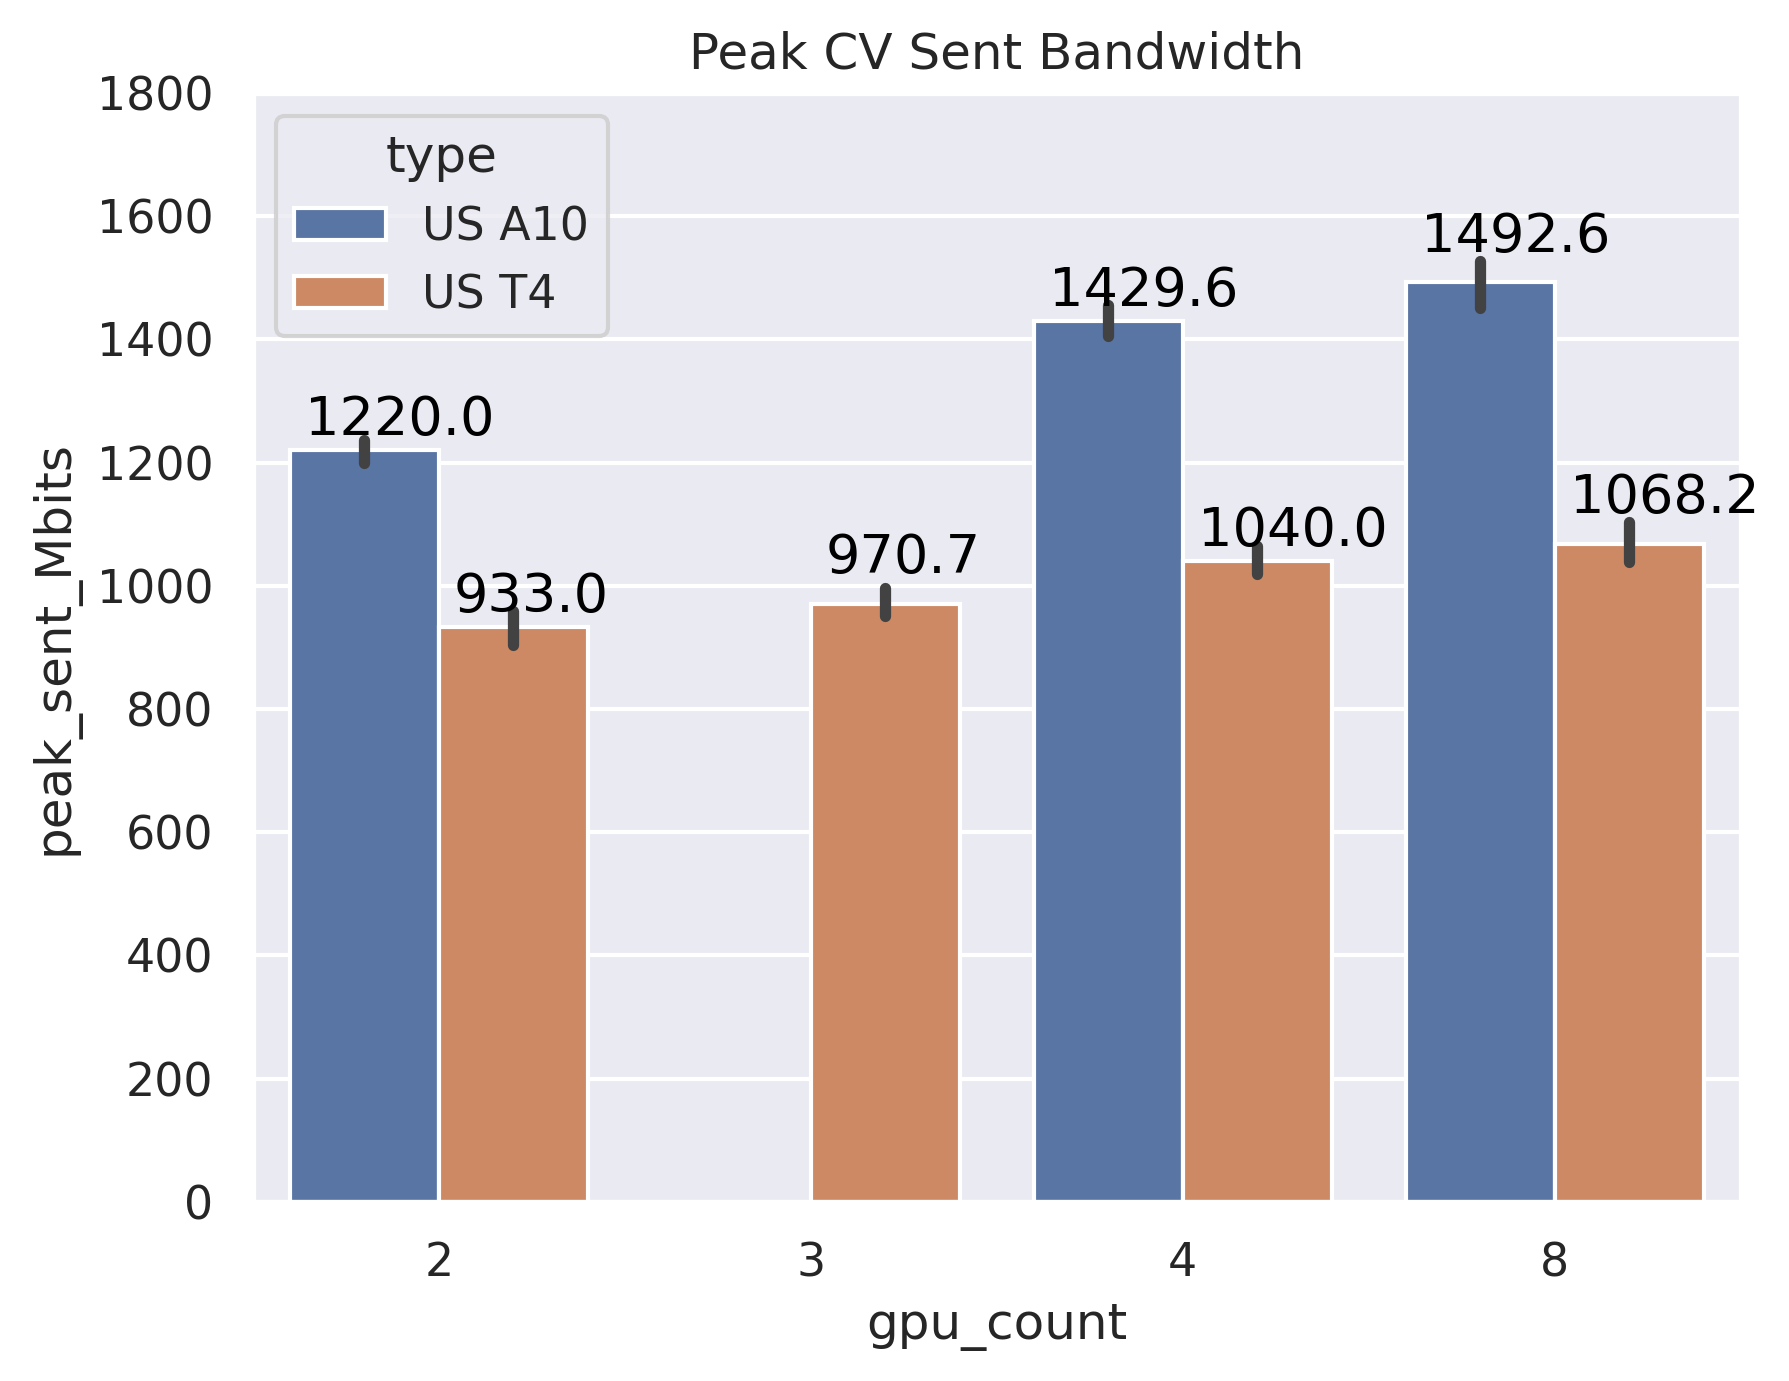

In [14]:
temp_df = pd.concat(objs=[cv_US_A10_bandwidths_df, cloud_cv_US_T4_bandwidths_df])

ax = sns.barplot(
    data = temp_df.query("gpu_count!=6"),
    x = "gpu_count",
    y = "peak_sent_Mbits",
    hue = "type"
)
plt.title("Peak CV Sent Bandwidth")
plt.ylim(0, 1800)
show_values_on_barplot(ax, height=25, rotation=0, decimals=1, fontsize=13)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


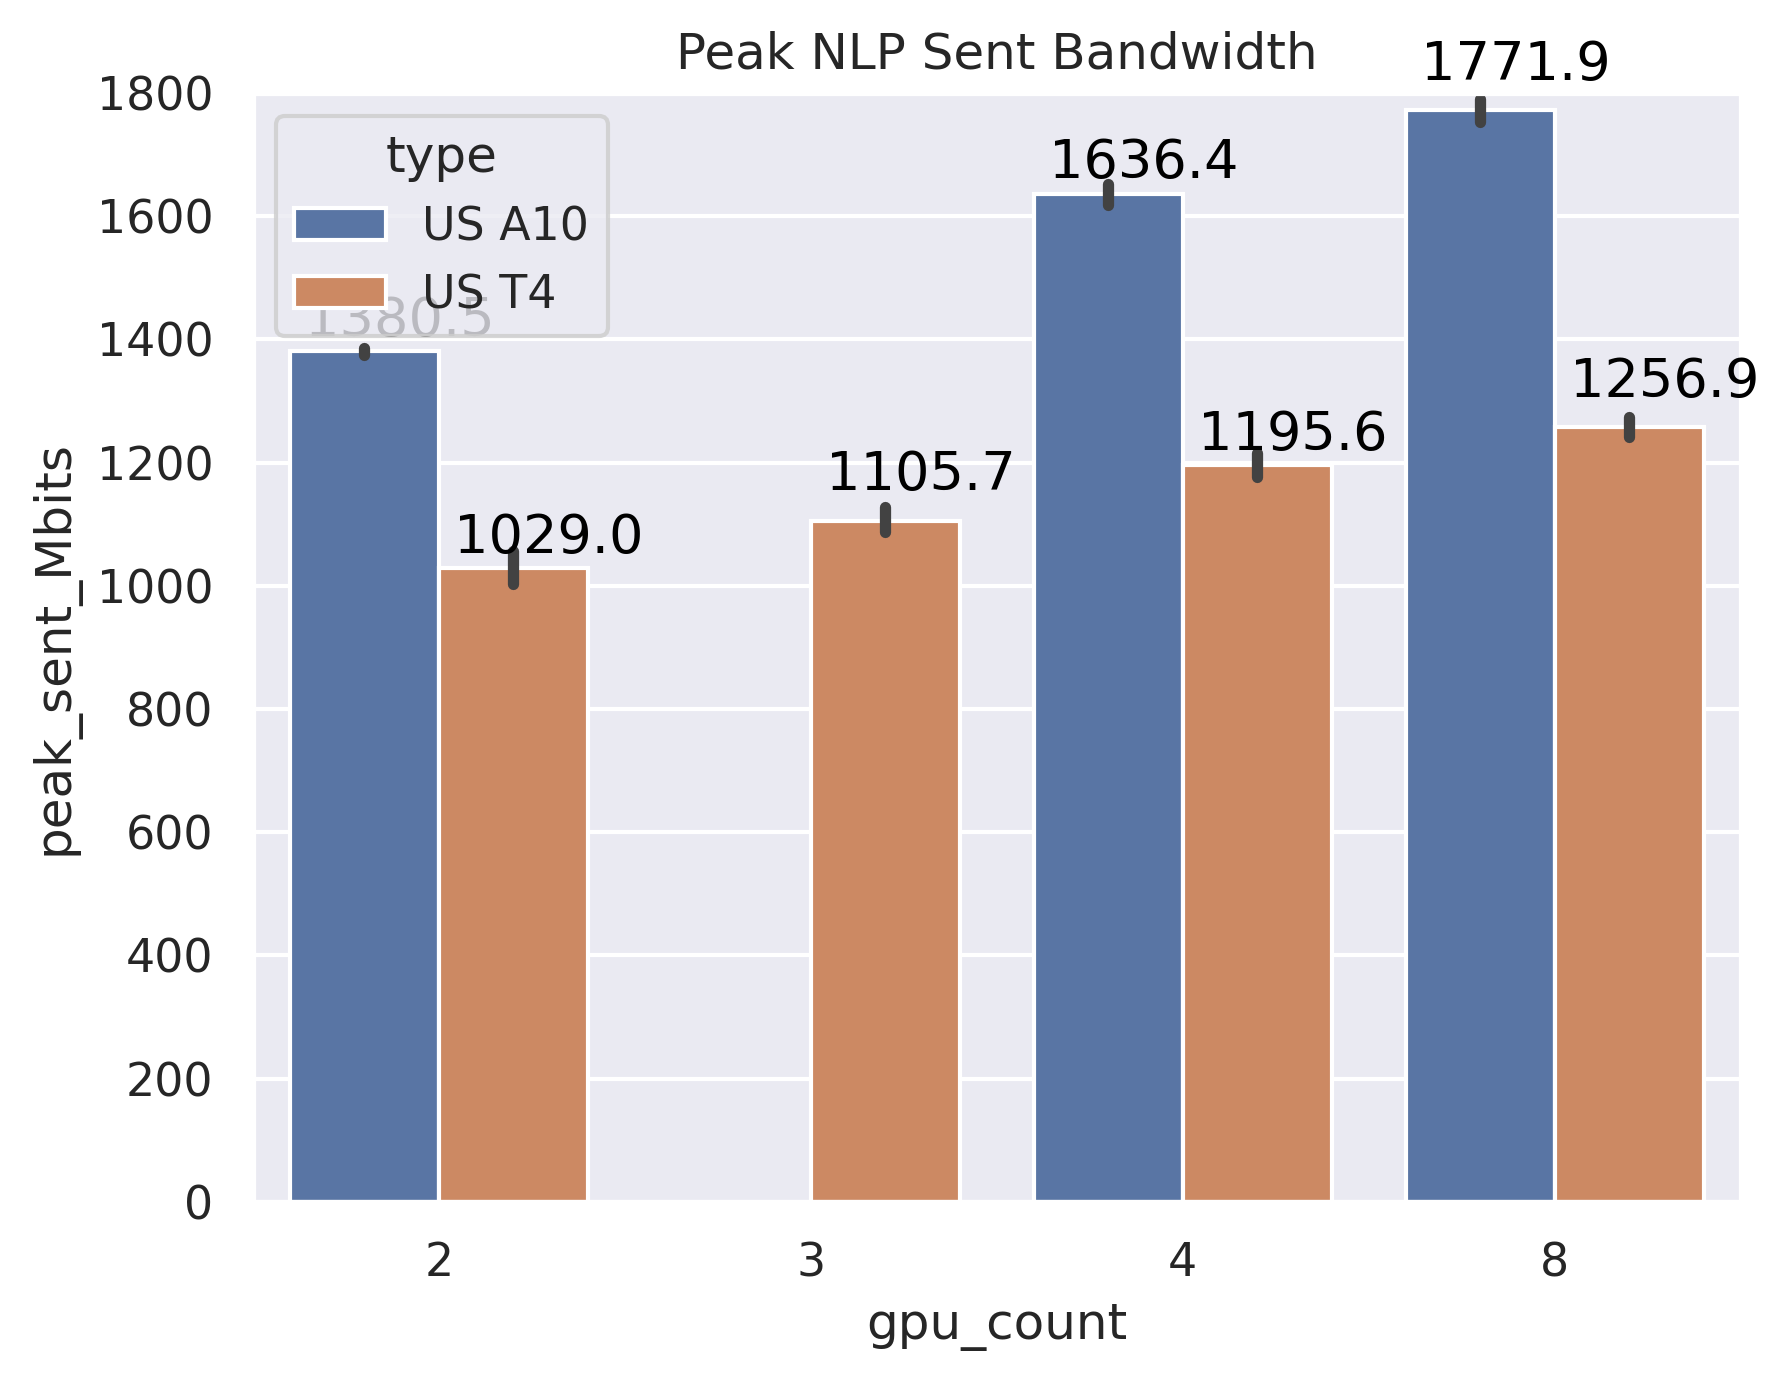

In [15]:
temp_df = pd.concat(objs=[nlp_US_A10_bandwidths_df, cloud_nlp_US_T4_bandwidths_df])

ax = sns.barplot(
    data = temp_df.query("gpu_count!=6"),
    x = "gpu_count",
    y = "peak_sent_Mbits",
    hue = "type"
)
plt.title("Peak NLP Sent Bandwidth")
plt.ylim(0, 1800)
show_values_on_barplot(ax, height=25, rotation=0, decimals=1, fontsize=13)

# Multi-Cloud Cost Analysis

In [8]:
def get_sent_bytes(run_name, val_dict):
    
    hivemind_runs = get_run_by_infix(
            runs = get_runs(run_name = run_name),
            infix = "bee")

    run_list = []
    
    for run in hivemind_runs:
        df = get_clean_history(run=run, filter_by="hardware")
        
        #debug = False
        #NON_LOCAL_STEP_CUTOFF_S = compute_local_step_cutoff(df["02_timing/opt_step_time_s"], debug=debug)
        #averaging_ix = df.index[df["02_timing/opt_step_time_s"] >= NON_LOCAL_STEP_CUTOFF_S].tolist()

        agg_dict = {
            "data_sent_GB": [],
            "data_recv_GB": [],
            "dataloading_recv_acc_GB": [],
            "runtime_s": [],
        }
    
        # total amount of data
        data_sent_GB = df["bandwidth/net_sent_sys_bandwidth_Mbits"].sum() / 8 / 1024
        data_recv_GB = df["bandwidth/net_recv_sys_bandwidth_Mbits"].sum() / 8 / 1024
        runtime_s = df["_runtime"].max()
        debug = False
        NON_LOCAL_STEP_CUTOFF_S = compute_local_step_cutoff(df["02_timing/opt_step_time_s"], debug=debug)
        averaging_ix = df.index[df["02_timing/opt_step_time_s"] >= NON_LOCAL_STEP_CUTOFF_S].tolist()

        last_ix_start = 0
        dataloading_recv_acc_GB = 0
        # get the averaging index, count seconds back based on averaging time
        # excluse that window and get the maximum bandwidth        
        for ix in averaging_ix:
            averaging_step_df = df.iloc[ix]
            averaging_step_time_s = averaging_step_df["02_timing/opt_step_time_s"]
            rounded_averaging_step_time_s = math.ceil(averaging_step_time_s)
            # everything before the averaging start
            window_averaging_df = df.iloc[last_ix_start:(ix - rounded_averaging_step_time_s)]
            # set new start after averaging finishes
            last_ix_start = ix + 1
            dataloading_recv_GB = window_averaging_df["bandwidth/net_recv_sys_bandwidth_Mbits"].sum() / 8 / 1024
            dataloading_recv_acc_GB += dataloading_recv_GB  
        
        agg_dict["data_sent_GB"].append(data_sent_GB)
        agg_dict["data_recv_GB"].append(data_recv_GB)
        agg_dict["dataloading_recv_acc_GB"].append(dataloading_recv_acc_GB)
        agg_dict["runtime_s"].append(runtime_s)

        agg_df = pd.DataFrame(agg_dict)
        agg_df["hostname"] = run.config.get("host")
        run_list.append(agg_df)

    all_runs_df = pd.concat(objs=run_list)
    all_runs_df = all_runs_df.reset_index(drop=True)
    
    for key, val in val_dict.items():
        all_runs_df[key] = val
    return all_runs_df

In [9]:
cv_4xGC_bw_df = get_sent_bytes(run_name="hivemind-77", val_dict={ 'name':"CV D-1" })
cv_2xGC_2xAWS_bw_df = get_sent_bytes(run_name="hivemind-113", val_dict={ 'name':"CV D-2" })
cv_2xGC_2xAZU_bw_df = get_sent_bytes(run_name="hivemind-117", val_dict={ 'name':"CV D-3" })

nlp_4xGC_bw_df = get_sent_bytes(run_name="hivemind-78", val_dict={ 'name':"NLP D-1" })
nlp_2xGC_2xAWS_bw_df = get_sent_bytes(run_name="hivemind-112", val_dict={ 'name':"NLP D-2" })
nlp_2xGC_2xAZU_bw_df = get_sent_bytes(run_name="hivemind-118", val_dict={ 'name':"NLP D-3" })

cv_c8_bw_df = get_sent_bytes(run_name="hivemind-92", val_dict={ 'name': "CV C-8" })
nlp_c8_bw_df = get_sent_bytes(run_name="hivemind-93", val_dict={ 'name': "NLP C-8" })

> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.


In [10]:
#display(cv_4xGC_bw_df)
display(nlp_4xGC_bw_df)
#display(cv_c8_bw_df)
display(nlp_c8_bw_df)

,data_sent_GB,data_recv_GB,dataloading_recv_acc_GB,runtime_s,hostname,name
0,4.964604,5.658425,0.715291,298,gc-t4-2,NLP D-1
1,4.963816,5.655554,0.706464,299,gc-t4-3,NLP D-1
2,4.965544,5.662547,0.714883,299,gc-t4-4,NLP D-1
3,4.964494,5.678446,0.741138,354,gc-t4-1,NLP D-1


,data_sent_GB,data_recv_GB,dataloading_recv_acc_GB,runtime_s,hostname,name
0,5.807958,6.131397,0.340447,317,gc-t4-21,NLP C-8
1,5.815311,6.129227,0.335727,317,gc-t4-20,NLP C-8
2,5.812145,6.143271,0.354511,320,gc-t4-11,NLP C-8
3,5.803841,6.133352,0.345682,319,gc-t4-10,NLP C-8
4,5.809221,6.185621,0.398068,324,gc-t4-2,NLP C-8
5,5.814115,6.188589,0.393928,329,gc-t4-5,NLP C-8
6,5.811957,6.193739,0.399619,328,gc-t4-6,NLP C-8
7,5.807738,6.290262,0.507067,413,gc-t4-1,NLP C-8


In [11]:
# backblaze
storage_cost_per_GB = 0.01
# GC VM cost
gc_on_demand_cost_per_hour = 0.572
gc_spot_cost_per_hour      = 0.180
gc_internal_egress_per_GB = 0.01
gc_external_egress_per_GB = 0.01
# AWS VM cost
aws_on_demand_cost_per_hour = 0.802
aws_spot_cost_per_hour      = 0.395
aws_internal_egress_per_GB = 0.01
aws_external_egress_per_GB = 0.01
# Azure VM cost
azure_on_demand_cost_per_hour = 0.489
azure_spot_cost_per_hour      = 0.134
azure_internal_egress_per_GB = 0.00
azure_external_egress_per_GB = 0.02

def to_GiB(gb):
    return gb * 0.93132257461548

In [12]:
display(cv_4xGC_bw_df)
display(cv_2xGC_2xAZU_bw_df)
display(cv_2xGC_2xAWS_bw_df)
#cv_4xGC_bw_df["dataloading_recv_GB_per_sec"] = cv_4xGC_bw_df["dataloading_recv_acc_GB"] / cv_4xGC_bw_df["runtime_s"]
#nlp_4xGC_bw_df["dataloading_recv_GB_per_sec"] = nlp_4xGC_bw_df["dataloading_recv_acc_GB"] / nlp_4xGC_bw_df["runtime_s"]

,data_sent_GB,data_recv_GB,dataloading_recv_acc_GB,runtime_s,hostname,name
0,1.778364,4.727994,2.967858,726,gc-t4-4,CV D-1
1,1.778726,4.709034,2.956004,726,gc-t4-2,CV D-1
2,1.777838,4.690798,2.922031,726,gc-t4-3,CV D-1
3,1.778205,4.718729,2.960752,780,gc-t4-1,CV D-1


,data_sent_GB,data_recv_GB,dataloading_recv_acc_GB,runtime_s,hostname,name
0,1.773190,4.594840,2.841451,721,gc-t4-2,CV D-3
1,3.615780,9.798679,6.231709,721,azure-t4-2,CV D-3
2,3.617450,9.846379,6.269601,722,azure-t4-1,CV D-3
3,1.773308,4.553393,2.798254,775,gc-t4-1,CV D-3


,data_sent_GB,data_recv_GB,dataloading_recv_acc_GB,runtime_s,hostname,name
0,1.847268,4.842688,3.039048,716,aws-t4-1,CV D-2
1,1.844796,4.781236,2.973883,716,aws-t4-2,CV D-2
2,1.775906,4.696945,2.925990,720,gc-t4-2,CV D-2
3,1.776308,4.781274,3.018947,788,gc-t4-1,CV D-2


In [13]:
def create_intra_us_cost_breakdown(cv_bw_df,
                               nlp_bw_df,
                               internal_egress_ratio,
                               external_egress_ratio):
    agg_dict = {
        "Cloud": [],
        "VM Spot": [],
        "VM On-Demand": [],
        "Egress Internal": [],
        "Egress External": [],
        "Dataloading": [],
        "Model": []
    }

    def add_sample_to_agg(cloud, vm_spot, vm_on_demand, egress_internal, egress_external, dataloading, model):
        agg_dict["Cloud"].append(cloud)
        agg_dict["VM Spot"].append(vm_spot)
        agg_dict["VM On-Demand"].append(vm_on_demand)
        agg_dict["Egress Internal"].append(egress_internal)
        agg_dict["Egress External"].append(egress_external)
        agg_dict["Dataloading"].append(dataloading)
        agg_dict["Model"].append(model)

    def get_ratios(bw_df):
        dataload_cost_per_second = bw_df["dataloading_recv_acc_GB"].mean() * storage_cost_per_GB / bw_df["runtime_s"].mean()
        internal_egress = bw_df["data_sent_GB"].mean() * internal_egress_ratio / bw_df["runtime_s"].mean()
        external_egress = bw_df["data_sent_GB"].mean() * external_egress_ratio / bw_df["runtime_s"].mean()
        print(f"Internal ingress per second: {internal_egress}")

        return dataload_cost_per_second, internal_egress, external_egress

    cv_dataload_cost_per_second, cv_internal_egress_per_second, cv_external_egress_per_second = get_ratios(bw_df = cv_bw_df)
    cv_dataload_cost_hour = cv_dataload_cost_per_second * 60 * 60
    cv_internal_egress_per_second = cv_internal_egress_per_second * 60 * 60
    cv_external_egress_per_second = cv_external_egress_per_second * 60 * 60
    
    cv_gc_internal_egress_per_hour = cv_internal_egress_per_second * gc_internal_egress_per_GB
    cv_gc_external_egress_per_hour = cv_external_egress_per_second * gc_external_egress_per_GB
    cv_aws_internal_egress_per_hour = cv_internal_egress_per_second * aws_internal_egress_per_GB
    cv_aws_external_egress_per_hour = cv_external_egress_per_second * aws_external_egress_per_GB
    cv_azure_internal_egress_per_hour = cv_internal_egress_per_second * azure_internal_egress_per_GB
    cv_azure_external_egress_per_hour = cv_external_egress_per_second * azure_external_egress_per_GB

    nlp_dataload_cost_per_second, nlp_internal_egress_per_second, nlp_external_egress_per_second = get_ratios(bw_df = nlp_bw_df)
    nlp_dataload_cost_hour = nlp_dataload_cost_per_second * 60 * 60
    nlp_internal_egress_per_second = nlp_internal_egress_per_second * 60 * 60
    nlp_external_egress_per_second = nlp_external_egress_per_second * 60 * 60

    nlp_gc_internal_egress_per_hour = nlp_internal_egress_per_second * gc_internal_egress_per_GB
    nlp_gc_external_egress_per_hour = nlp_external_egress_per_second * gc_external_egress_per_GB
    nlp_aws_internal_egress_per_hour = nlp_internal_egress_per_second * aws_internal_egress_per_GB
    nlp_aws_external_egress_per_hour = nlp_external_egress_per_second * aws_external_egress_per_GB
    nlp_azure_internal_egress_per_hour = nlp_internal_egress_per_second * azure_internal_egress_per_GB
    nlp_azure_external_egress_per_hour = nlp_external_egress_per_second * azure_external_egress_per_GB

    add_sample_to_agg(model="ConvNextLarge", cloud="GC",
                      vm_spot=gc_spot_cost_per_hour,
                      vm_on_demand=gc_on_demand_cost_per_hour,
                      egress_internal=cv_gc_internal_egress_per_hour,
                      egress_external=cv_gc_external_egress_per_hour,
                      dataloading=cv_dataload_cost_hour)

    add_sample_to_agg(model="ConvNextLarge", cloud="AWS",
                      vm_spot=aws_spot_cost_per_hour,
                      vm_on_demand=aws_on_demand_cost_per_hour,
                      egress_internal=cv_aws_internal_egress_per_hour,
                      egress_external=cv_aws_external_egress_per_hour,
                      dataloading=cv_dataload_cost_hour)

    add_sample_to_agg(model="ConvNextLarge", cloud="Azure",
                      vm_spot=azure_spot_cost_per_hour,
                      vm_on_demand=azure_on_demand_cost_per_hour,
                      egress_internal=cv_azure_internal_egress_per_hour,
                      egress_external=cv_azure_external_egress_per_hour,
                      dataloading=cv_dataload_cost_hour)

    add_sample_to_agg(model="RoBERTaXLM", cloud="GC",
                      vm_spot=gc_spot_cost_per_hour,
                      vm_on_demand=gc_on_demand_cost_per_hour,
                      egress_internal=nlp_gc_internal_egress_per_hour,
                      egress_external=nlp_gc_external_egress_per_hour,
                      dataloading=nlp_dataload_cost_hour)

    add_sample_to_agg(model="RoBERTaXLM", cloud="AWS",
                      vm_spot=aws_spot_cost_per_hour,
                      vm_on_demand=aws_on_demand_cost_per_hour,
                      egress_internal=nlp_aws_internal_egress_per_hour,
                      egress_external=nlp_aws_external_egress_per_hour,
                      dataloading=nlp_dataload_cost_hour)

    add_sample_to_agg(model="RoBERTaXLM", cloud="Azure",
                      vm_spot=azure_spot_cost_per_hour,
                      vm_on_demand=azure_on_demand_cost_per_hour,
                      egress_internal=nlp_azure_internal_egress_per_hour,
                      egress_external=nlp_azure_external_egress_per_hour,
                      dataloading=nlp_dataload_cost_hour)

    agg_df = pd.DataFrame(agg_dict)
    display(agg_df)
    return agg_df

d1_4xT4_cost_breakdown_df = create_intra_us_cost_breakdown(
    cv_bw_df=cv_4xGC_bw_df,
    nlp_bw_df=nlp_4xGC_bw_df,
    internal_egress_ratio=1/3,
    external_egress_ratio=2/3)

Internal ingress per second: 0.0008015700000667159
Internal ingress per second: 0.005295588956181678


,Cloud,VM Spot,VM On-Demand,Egress Internal,Egress External,Dataloading,Model
0,GC,0.180,0.572,0.028857,0.057713,0.143691,ConvNextLarge
1,AWS,0.395,0.802,0.028857,0.057713,0.143691,ConvNextLarge
2,Azure,0.134,0.489,0.000000,0.115426,0.143691,ConvNextLarge
3,GC,0.180,0.572,0.190641,0.381282,0.082880,RoBERTaXLM
4,AWS,0.395,0.802,0.190641,0.381282,0.082880,RoBERTaXLM
5,Azure,0.134,0.489,0.000000,0.762565,0.082880,RoBERTaXLM


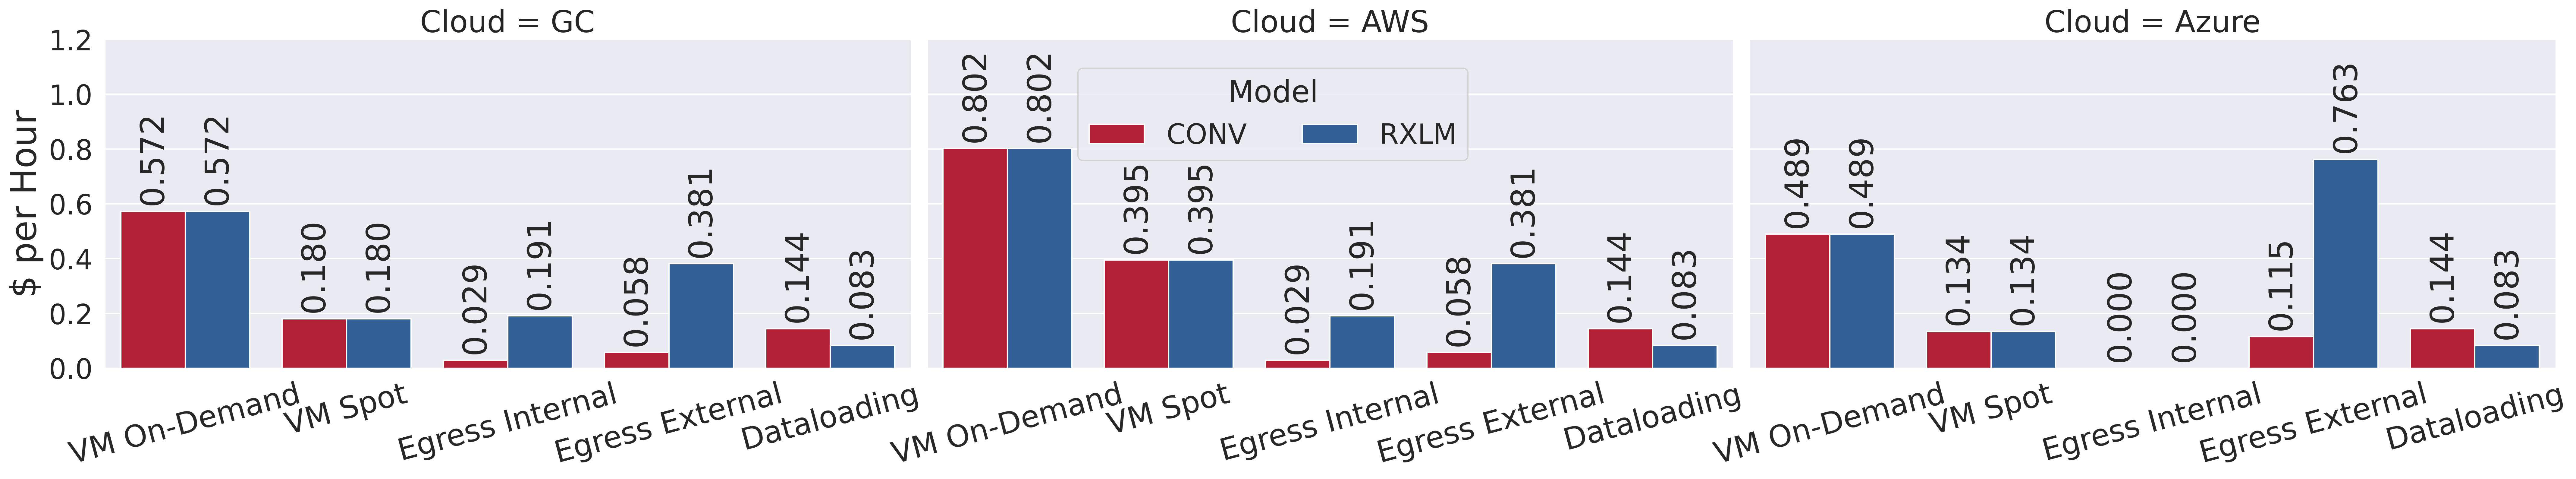

In [33]:
sns.set(context="paper")
sns.set(palette=cv_nlp_palette)
temp_df = d1_4xT4_cost_breakdown_df.melt(id_vars = ["Cloud", "Model"], value_vars=["VM On-Demand", "VM Spot", "Egress Internal", "Egress External", "Dataloading"])

temp_df = temp_df.replace("ConvNextLarge", "CONV")
temp_df = temp_df.replace("RoBERTaXLM", "RXLM")

g = sns.catplot(
    data=temp_df,
    kind="bar",
    y="value", x="variable", hue="Model", col="Cloud",
    height=4.7, aspect=2
)
g.set_axis_labels("", "$ per Hour", size=28)
g.set_xticklabels(rotation=15, size=24)
sns.move_legend(g, "lower center", bbox_to_anchor=(.47, 0.6), ncol=3, title="Model", frameon=True,  fontsize=22, title_fontsize=24)
g.set_titles(size=24)
g.set(ylim=(0, 1.2))
g.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2], size=22)

for ax in g.axes.flat:
    ax.bar_label(ax.containers[0], fmt="%.3f", rotation=90, padding=5, size=26)
    ax.bar_label(ax.containers[1], fmt="%.3f", rotation=90, padding=5, size=26)

save_fig(f"multi_cloud_cost_comparison_d3")

In [25]:
# all spot prices taken on the 12th of May at 02:40

# backblaze
storage_cost_per_GB = 0.01
# GC VM cost
gc_on_demand_cost_per_hour = (0.51 + 0.54 + 0.55 + 0.69) / 4 # US, EU, ASIA, AUS
gc_spot_cost_per_hour      = (0.20 + 0.20 + 0.15 + 0.18) / 4 # US, EU, ASIA, AUS
gc_internal_egress_per_GB = 0.01
gc_external_egress_between_continents_per_GB = 0.08
gc_external_egress_to_oce_per_GB = 0.15
# AWS VM cost
aws_on_demand_cost_per_hour = (0.722 + 0.798 + 1.158 + 0.978) / 4 # US, EU, ASIA, AUS
aws_spot_cost_per_hour      = (0.4388 + 0.2394 + 0.3474 + 0.2934) / 4 # US, EU, ASIA, AUS
aws_internal_egress_per_GB = 0.01
aws_external_egress_between_continents_per_GB = 0.02
aws_external_egress_to_oce_per_GB = 0.02
# Azure VM cost
def to_hours(cost_per_month):
    return cost_per_month / 30 / 24

azure_on_demand_cost_per_hour = (to_hours(460.34) + to_hours(480.34) + to_hours(537.28) + + to_hours(499.32)) / 4
azure_spot_cost_per_hour      = (0.15056 + 0.14542 + 0.18025 + 0.23130) / 4
azure_internal_egress_per_GB = 0.00
azure_external_egress_between_continents_per_GB = 0.02
azure_external_egress_to_oce_per_GB = 0.08

def to_GiB(gb):
    return gb * 0.93132257461548

def create_full_cost_breakdown(cv_bw_df,
                               nlp_bw_df,
                               internal_egress_ratio,
                               external_egress_ratio_zone,
                               external_egress_ratio_continent,
                               external_egress_ratio_oce):
    full_agg_dict = {
        "Cloud": [],
        "VM Spot": [],
        "VM On-Demand": [],
        "Egress Internal": [],
        "Egress External": [],
        "Dataloading": [],
        "Model": []
    }

    def add_sample_to_agg(cloud, vm_spot, vm_on_demand, egress_internal, egress_external, dataloading, model):
        full_agg_dict["Cloud"].append(cloud)
        full_agg_dict["VM Spot"].append(vm_spot)
        full_agg_dict["VM On-Demand"].append(vm_on_demand)
        full_agg_dict["Egress Internal"].append(egress_internal)
        full_agg_dict["Egress External"].append(egress_external)
        full_agg_dict["Dataloading"].append(dataloading)
        full_agg_dict["Model"].append(model)

    def get_ratios(bw_df):
        dataload_cost_per_second  = bw_df["dataloading_recv_acc_GB"].mean() * storage_cost_per_GB / bw_df["runtime_s"].mean()
        internal_egress           = bw_df["data_sent_GB"].mean() * internal_egress_ratio / bw_df["runtime_s"].mean()
        #external_egress_zone      = to_GiB(bw_df["data_sent_GB"].mean()) * external_egress_ratio_zone / bw_df["runtime_s"].mean()
        external_egress_continent = bw_df["data_sent_GB"].mean() * external_egress_ratio_continent / bw_df["runtime_s"].mean()
        external_egress_oce       = bw_df["data_sent_GB"].mean() * external_egress_ratio_oce / bw_df["runtime_s"].mean()
        return dataload_cost_per_second, \
                        internal_egress, \
              external_egress_continent, \
                    external_egress_oce
    
    cv_dataload_cost_per_second, \
     cv_internal_egress_per_second, \
     cv_external_egress_continent_per_second, \
     cv_external_egress_oce_per_second = get_ratios(bw_df = cv_bw_df)
    cv_dataload_cost_hour = cv_dataload_cost_per_second * 60 * 60
    
    cv_internal_egress_in_GB_per_hour           = cv_internal_egress_per_second           * 60 * 60
    cv_external_egress_continent_in_GB_per_hour = cv_external_egress_continent_per_second * 60 * 60
    cv_external_egress_oce_in_GB_per_hour       = cv_external_egress_oce_per_second       * 60 * 60

    cv_gc_internal_egress_cost_per_hour           = cv_internal_egress_in_GB_per_hour           * gc_internal_egress_per_GB
    cv_gc_external_egress_continent_cost_per_hour = cv_external_egress_continent_in_GB_per_hour * gc_external_egress_between_continents_per_GB
    cv_gc_external_egress_oce_cost_per_hour       = cv_external_egress_oce_in_GB_per_hour       * gc_external_egress_to_oce_per_GB
    cv_gc_external_egress_cost_per_hour = cv_gc_external_egress_continent_cost_per_hour + \
                                          cv_gc_external_egress_oce_cost_per_hour
    
    cv_aws_internal_egress_cost_per_hour           = cv_internal_egress_in_GB_per_hour           * aws_internal_egress_per_GB
    cv_aws_external_egress_continent_cost_per_hour = cv_external_egress_continent_in_GB_per_hour * aws_external_egress_between_continents_per_GB
    cv_aws_external_egress_oce_cost_per_hour       = cv_external_egress_oce_in_GB_per_hour       * aws_external_egress_to_oce_per_GB
    cv_aws_external_egress_cost_per_hour = cv_aws_external_egress_continent_cost_per_hour + \
                                           cv_aws_external_egress_oce_cost_per_hour

    cv_azure_internal_egress_cost_per_hour           = cv_internal_egress_in_GB_per_hour           * azure_internal_egress_per_GB
    cv_azure_external_egress_continent_cost_per_hour = cv_external_egress_continent_in_GB_per_hour * azure_external_egress_between_continents_per_GB
    cv_azure_external_egress_oce_cost_per_hour       = cv_external_egress_oce_in_GB_per_hour       * azure_external_egress_to_oce_per_GB
    cv_azure_external_egress_cost_per_hour = cv_azure_external_egress_continent_cost_per_hour + \
                                             cv_azure_external_egress_oce_cost_per_hour
    
    nlp_dataload_cost_per_second, \
        nlp_internal_egress_per_second, \
        nlp_external_egress_continent_per_second, \
        nlp_external_egress_oce_per_second = get_ratios(bw_df = nlp_bw_df)
    nlp_dataload_cost_hour = nlp_dataload_cost_per_second * 60 * 60
    nlp_internal_egress_in_GB_per_hour           = nlp_internal_egress_per_second           * 60 * 60
    nlp_external_egress_continent_in_GB_per_hour = nlp_external_egress_continent_per_second * 60 * 60
    nlp_external_egress_oce_in_GB_per_hour       = nlp_external_egress_oce_per_second       * 60 * 60

    nlp_gc_internal_egress_cost_per_hour = nlp_internal_egress_in_GB_per_hour * gc_internal_egress_per_GB
    nlp_gc_external_egress_continent_cost_per_hour = nlp_external_egress_continent_in_GB_per_hour * gc_external_egress_between_continents_per_GB
    nlp_gc_external_egress_oce_cost_per_hour = nlp_external_egress_oce_in_GB_per_hour * gc_external_egress_to_oce_per_GB
    nlp_gc_external_egress_cost_per_hour = nlp_gc_external_egress_continent_cost_per_hour + \
                                          nlp_gc_external_egress_oce_cost_per_hour
    
    nlp_aws_internal_egress_cost_per_hour = nlp_internal_egress_in_GB_per_hour * aws_internal_egress_per_GB
    nlp_aws_external_egress_continent_cost_per_hour = nlp_external_egress_continent_in_GB_per_hour * aws_external_egress_between_continents_per_GB
    nlp_aws_external_egress_oce_cost_per_hour = nlp_external_egress_oce_in_GB_per_hour * aws_external_egress_to_oce_per_GB
    nlp_aws_external_egress_cost_per_hour = nlp_aws_external_egress_continent_cost_per_hour + \
                                          nlp_aws_external_egress_oce_cost_per_hour

    nlp_azure_internal_egress_cost_per_hour = nlp_internal_egress_in_GB_per_hour * azure_internal_egress_per_GB
    nlp_azure_external_egress_continent_cost_per_hour = nlp_external_egress_continent_in_GB_per_hour * azure_external_egress_between_continents_per_GB
    nlp_azure_external_egress_oce_cost_per_hour = nlp_external_egress_oce_in_GB_per_hour * azure_external_egress_to_oce_per_GB
    nlp_azure_external_egress_cost_per_hour = nlp_azure_external_egress_continent_cost_per_hour + \
                                          nlp_azure_external_egress_oce_cost_per_hour

    add_sample_to_agg(model="ConvNextLarge", cloud="GC",
                      vm_spot=gc_spot_cost_per_hour,
                      vm_on_demand=gc_on_demand_cost_per_hour,
                      egress_internal=cv_gc_internal_egress_cost_per_hour,
                      egress_external=cv_gc_external_egress_cost_per_hour,
                      dataloading=cv_dataload_cost_hour)

    add_sample_to_agg(model="ConvNextLarge", cloud="AWS",
                      vm_spot=aws_spot_cost_per_hour,
                      vm_on_demand=aws_on_demand_cost_per_hour,
                      egress_internal=cv_aws_internal_egress_cost_per_hour,
                      egress_external=cv_aws_external_egress_cost_per_hour,
                      dataloading=cv_dataload_cost_hour)

    add_sample_to_agg(model="ConvNextLarge", cloud="Azure",
                      vm_spot=azure_spot_cost_per_hour,
                      vm_on_demand=azure_on_demand_cost_per_hour,
                      egress_internal=cv_azure_internal_egress_cost_per_hour,
                      egress_external=cv_azure_external_egress_cost_per_hour,
                      dataloading=cv_dataload_cost_hour)

    add_sample_to_agg(model="RoBERTaXLM", cloud="GC",
                      vm_spot=gc_spot_cost_per_hour,
                      vm_on_demand=gc_on_demand_cost_per_hour,
                      egress_internal=nlp_gc_internal_egress_cost_per_hour,
                      egress_external=nlp_gc_external_egress_cost_per_hour,
                      dataloading=nlp_dataload_cost_hour)

    add_sample_to_agg(model="RoBERTaXLM", cloud="AWS",
                      vm_spot=aws_spot_cost_per_hour,
                      vm_on_demand=aws_on_demand_cost_per_hour,
                      egress_internal=nlp_aws_internal_egress_cost_per_hour,
                      egress_external=nlp_aws_external_egress_cost_per_hour,
                      dataloading=nlp_dataload_cost_hour)

    add_sample_to_agg(model="RoBERTaXLM", cloud="Azure",
                      vm_spot=azure_spot_cost_per_hour,
                      vm_on_demand=azure_on_demand_cost_per_hour,
                      egress_internal=nlp_azure_internal_egress_cost_per_hour,
                      egress_external=nlp_azure_external_egress_cost_per_hour,
                      dataloading=nlp_dataload_cost_hour)

    full_agg_df = pd.DataFrame(full_agg_dict)
    display(full_agg_df)
    return full_agg_df

c8_8xT4_cost_breakdown_df = create_full_cost_breakdown(
    cv_bw_df=cv_c8_bw_df,
    nlp_bw_df=nlp_c8_bw_df,
    internal_egress_ratio=8/20,
    external_egress_ratio_zone=0,
    external_egress_ratio_continent=6/20,
    external_egress_ratio_oce=6/20)

,Cloud,VM Spot,VM On-Demand,Egress Internal,Egress External,Dataloading,Model
0,GC,0.182500,0.572500,0.068456,1.180865,0.122736,ConvNextLarge
1,AWS,0.329750,0.914000,0.068456,0.205368,0.122736,ConvNextLarge
2,Azure,0.176882,0.686556,0.000000,0.513419,0.122736,ConvNextLarge
3,GC,0.182500,0.572500,0.250973,4.329284,0.041508,RoBERTaXLM
4,AWS,0.329750,0.914000,0.250973,0.752919,0.041508,RoBERTaXLM
5,Azure,0.176882,0.686556,0.000000,1.882297,0.041508,RoBERTaXLM


In [26]:
display(c8_8xT4_cost_breakdown_df)
display(d1_4xT4_cost_breakdown_df)

,Cloud,VM Spot,VM On-Demand,Egress Internal,Egress External,Dataloading,Model
0,GC,0.182500,0.572500,0.068456,1.180865,0.122736,ConvNextLarge
1,AWS,0.329750,0.914000,0.068456,0.205368,0.122736,ConvNextLarge
2,Azure,0.176882,0.686556,0.000000,0.513419,0.122736,ConvNextLarge
3,GC,0.182500,0.572500,0.250973,4.329284,0.041508,RoBERTaXLM
4,AWS,0.329750,0.914000,0.250973,0.752919,0.041508,RoBERTaXLM
5,Azure,0.176882,0.686556,0.000000,1.882297,0.041508,RoBERTaXLM


,Cloud,VM Spot,VM On-Demand,Egress Internal,Egress External,Dataloading,Model
0,GC,0.180,0.572,0.028857,0.057713,0.143691,ConvNextLarge
1,AWS,0.395,0.802,0.028857,0.057713,0.143691,ConvNextLarge
2,Azure,0.134,0.489,0.000000,0.115426,0.143691,ConvNextLarge
3,GC,0.180,0.572,0.190641,0.381282,0.082880,RoBERTaXLM
4,AWS,0.395,0.802,0.190641,0.381282,0.082880,RoBERTaXLM
5,Azure,0.134,0.489,0.000000,0.762565,0.082880,RoBERTaXLM


<Figure size 2400x900 with 0 Axes>

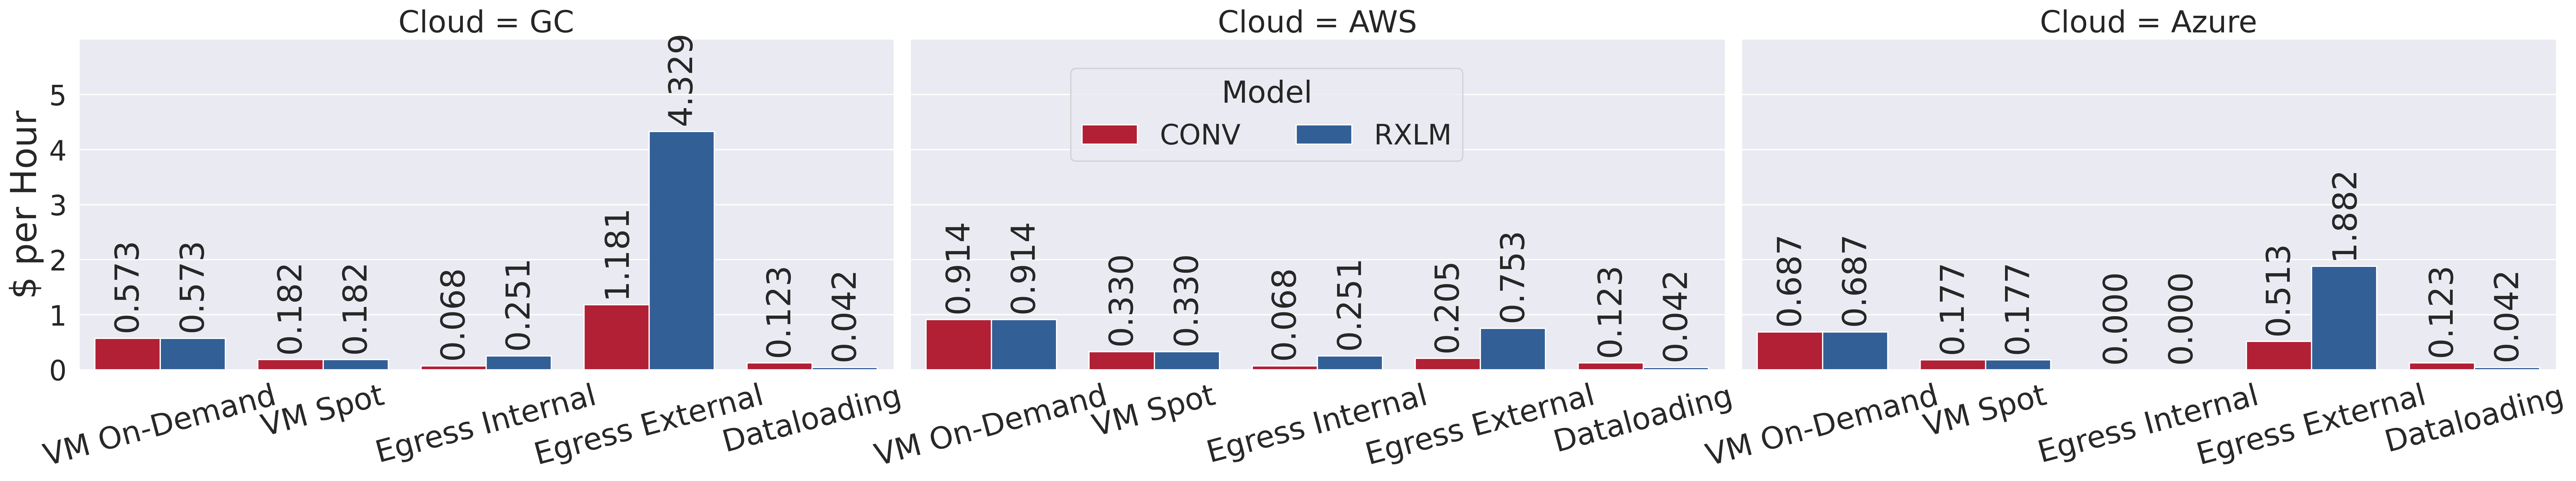

In [32]:
sns.set(context="paper")
sns.set(palette=cv_nlp_palette)

temp_df = c8_8xT4_cost_breakdown_df.melt(id_vars = ["Cloud", "Model"], value_vars=["VM On-Demand", "VM Spot", "Egress Internal", "Egress External", "Dataloading"])
temp_df = temp_df.replace("ConvNextLarge", "CONV")
temp_df = temp_df.replace("RoBERTaXLM", "RXLM")
plt.figure(figsize=(8,3))
g = sns.catplot(
    data=temp_df,
    kind="bar",
    y="value", x="variable", hue="Model", col="Cloud",
    height=4.7, aspect=2
)

g.set_axis_labels("", "$ per Hour", size=28)
g.set_xticklabels(rotation=15, size=24)
sns.move_legend(g, "lower center", bbox_to_anchor=(.47, 0.6), ncol=3, title="Model", frameon=True,  fontsize=22, title_fontsize=24)
g.set_titles(size=24)
g.set_yticklabels([0,1,2,3,4,5], size=22)
g.set(ylim=(0, 6))

for ax in g.axes.flat:
    ax.bar_label(ax.containers[0], fmt="%.3f", rotation=90, padding=5, size=26)
    ax.bar_label(ax.containers[1], fmt="%.3f", rotation=90, padding=5, size=26)


save_fig(f"multi_cloud_cost_comparison_c8")

# Baseline Experiment Bandwidth Analysis

In [34]:
rn18_2xA10_32768_df    = get_sent_bytes(run_name="hivemind-284",val_dict={ "name": "RN18 2xA10", "gpu_count": 2})
rn50_2xA10_32768_df    = get_sent_bytes(run_name="hivemind-289",val_dict={ "name": "RN50 2xA10", "gpu_count": 2})
rn101_2xA10_32768_df   = get_sent_bytes(run_name="hivemind-290",val_dict={ "name": "RN152 2xA10", "gpu_count": 2})
wdrn101_2xA10_32768_df = get_sent_bytes(run_name="hivemind-295",val_dict={ "name": "WRN101 2xA10", "gpu_count": 2})
conv_2xA10_32768_df    = get_sent_bytes(run_name="hivemind-296",val_dict={ "name": "CONV 2xA10", "gpu_count": 2})

rn18_3xA10_32768_df    = get_sent_bytes(run_name="hivemind-306",val_dict={ "name": "RN18 3xA10", "gpu_count": 3})
rn50_3xA10_32768_df    = get_sent_bytes(run_name="hivemind-307",val_dict={ "name": "RN50 3xA10", "gpu_count": 3})
rn101_3xA10_32768_df   = get_sent_bytes(run_name="hivemind-308",val_dict={ "name": "RN152 3xA10", "gpu_count": 3})
wdrn101_3xA10_32768_df = get_sent_bytes(run_name="hivemind-309",val_dict={ "name": "WRN101 3xA10", "gpu_count": 3})
conv_3xA10_32768_df    = get_sent_bytes(run_name="hivemind-310",val_dict={ "name": "CONV 3xA10", "gpu_count": 3})

rn18_4xA10_32768_df    = get_sent_bytes(run_name="hivemind-315",val_dict={ "name": "RN18 4xA10", "gpu_count": 4})
rn50_4xA10_32768_df    = get_sent_bytes(run_name="hivemind-316",val_dict={ "name": "RN50 4xA10", "gpu_count": 4})
rn101_4xA10_32768_df   = get_sent_bytes(run_name="hivemind-317",val_dict={ "name": "RN152 4xA10", "gpu_count": 4})
wdrn101_4xA10_32768_df = get_sent_bytes(run_name="hivemind-318",val_dict={ "name": "WRN101 4xA10", "gpu_count": 4})
conv_4xA10_32768_df    = get_sent_bytes(run_name="hivemind-319",val_dict={ "name": "CONV 4xA10", "gpu_count": 4})

rn18_8xA10_32768_df    = get_sent_bytes(run_name="hivemind-325",val_dict={ "name": "RN18 8xA10", "gpu_count": 8})
rn50_8xA10_32768_df    = get_sent_bytes(run_name="hivemind-326",val_dict={ "name": "RN50 8xA10", "gpu_count": 8})
rn101_8xA10_32768_df   = get_sent_bytes(run_name="hivemind-327",val_dict={ "name": "RN152 8xA10", "gpu_count": 8})
wdrn101_8xA10_32768_df = get_sent_bytes(run_name="hivemind-328",val_dict={ "name": "WRN101 8xA10", "gpu_count": 8})
conv_8xA10_32768_df    = get_sent_bytes(run_name="hivemind-330",val_dict={ "name": "CONV 8xA10", "gpu_count": 8})

"""
baseline_bytes = pd.concat(objs=[
    rn18_2xA10_32768_df,    
    rn50_2xA10_32768_df,    
    rn101_2xA10_32768_df,   
    wdrn101_2xA10_32768_df, 
    conv_2xA10_32768_df,    
    rn18_3xA10_32768_df,    
    rn50_3xA10_32768_df,    
    rn101_3xA10_32768_df,   
    wdrn101_3xA10_32768_df, 
    conv_3xA10_32768_df,    
    rn18_4xA10_32768_df,    
    rn50_4xA10_32768_df,    
    rn101_4xA10_32768_df,   
    wdrn101_4xA10_32768_df, 
    conv_4xA10_32768_df,    
    rn18_8xA10_32768_df,    
    rn50_8xA10_32768_df,    
    rn101_8xA10_32768_df,   
    wdrn101_8xA10_32768_df, 
    conv_8xA10_32768_df
])
"""
cv_baseline_bytes = pd.concat(objs=[
    rn18_2xA10_32768_df,    
    rn18_3xA10_32768_df,    
    rn18_4xA10_32768_df,    
    rn18_8xA10_32768_df,
    rn50_2xA10_32768_df,    
    rn50_3xA10_32768_df,    
    rn50_4xA10_32768_df,    
    rn50_8xA10_32768_df,    
    rn101_2xA10_32768_df,  
    rn101_3xA10_32768_df,   
    rn101_4xA10_32768_df,   
    rn101_8xA10_32768_df,   
    wdrn101_2xA10_32768_df, 
    wdrn101_3xA10_32768_df, 
    wdrn101_4xA10_32768_df, 
    wdrn101_8xA10_32768_df, 
    conv_2xA10_32768_df,    
    conv_3xA10_32768_df,    
    conv_4xA10_32768_df,    
    conv_8xA10_32768_df
])
cv_baseline_bytes = cv_baseline_bytes.reset_index(drop=True)
cv_baseline_bytes["sent_MB_per_sec"] = cv_baseline_bytes["data_sent_GB"] * 1000 / cv_baseline_bytes["runtime_s"]

> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.


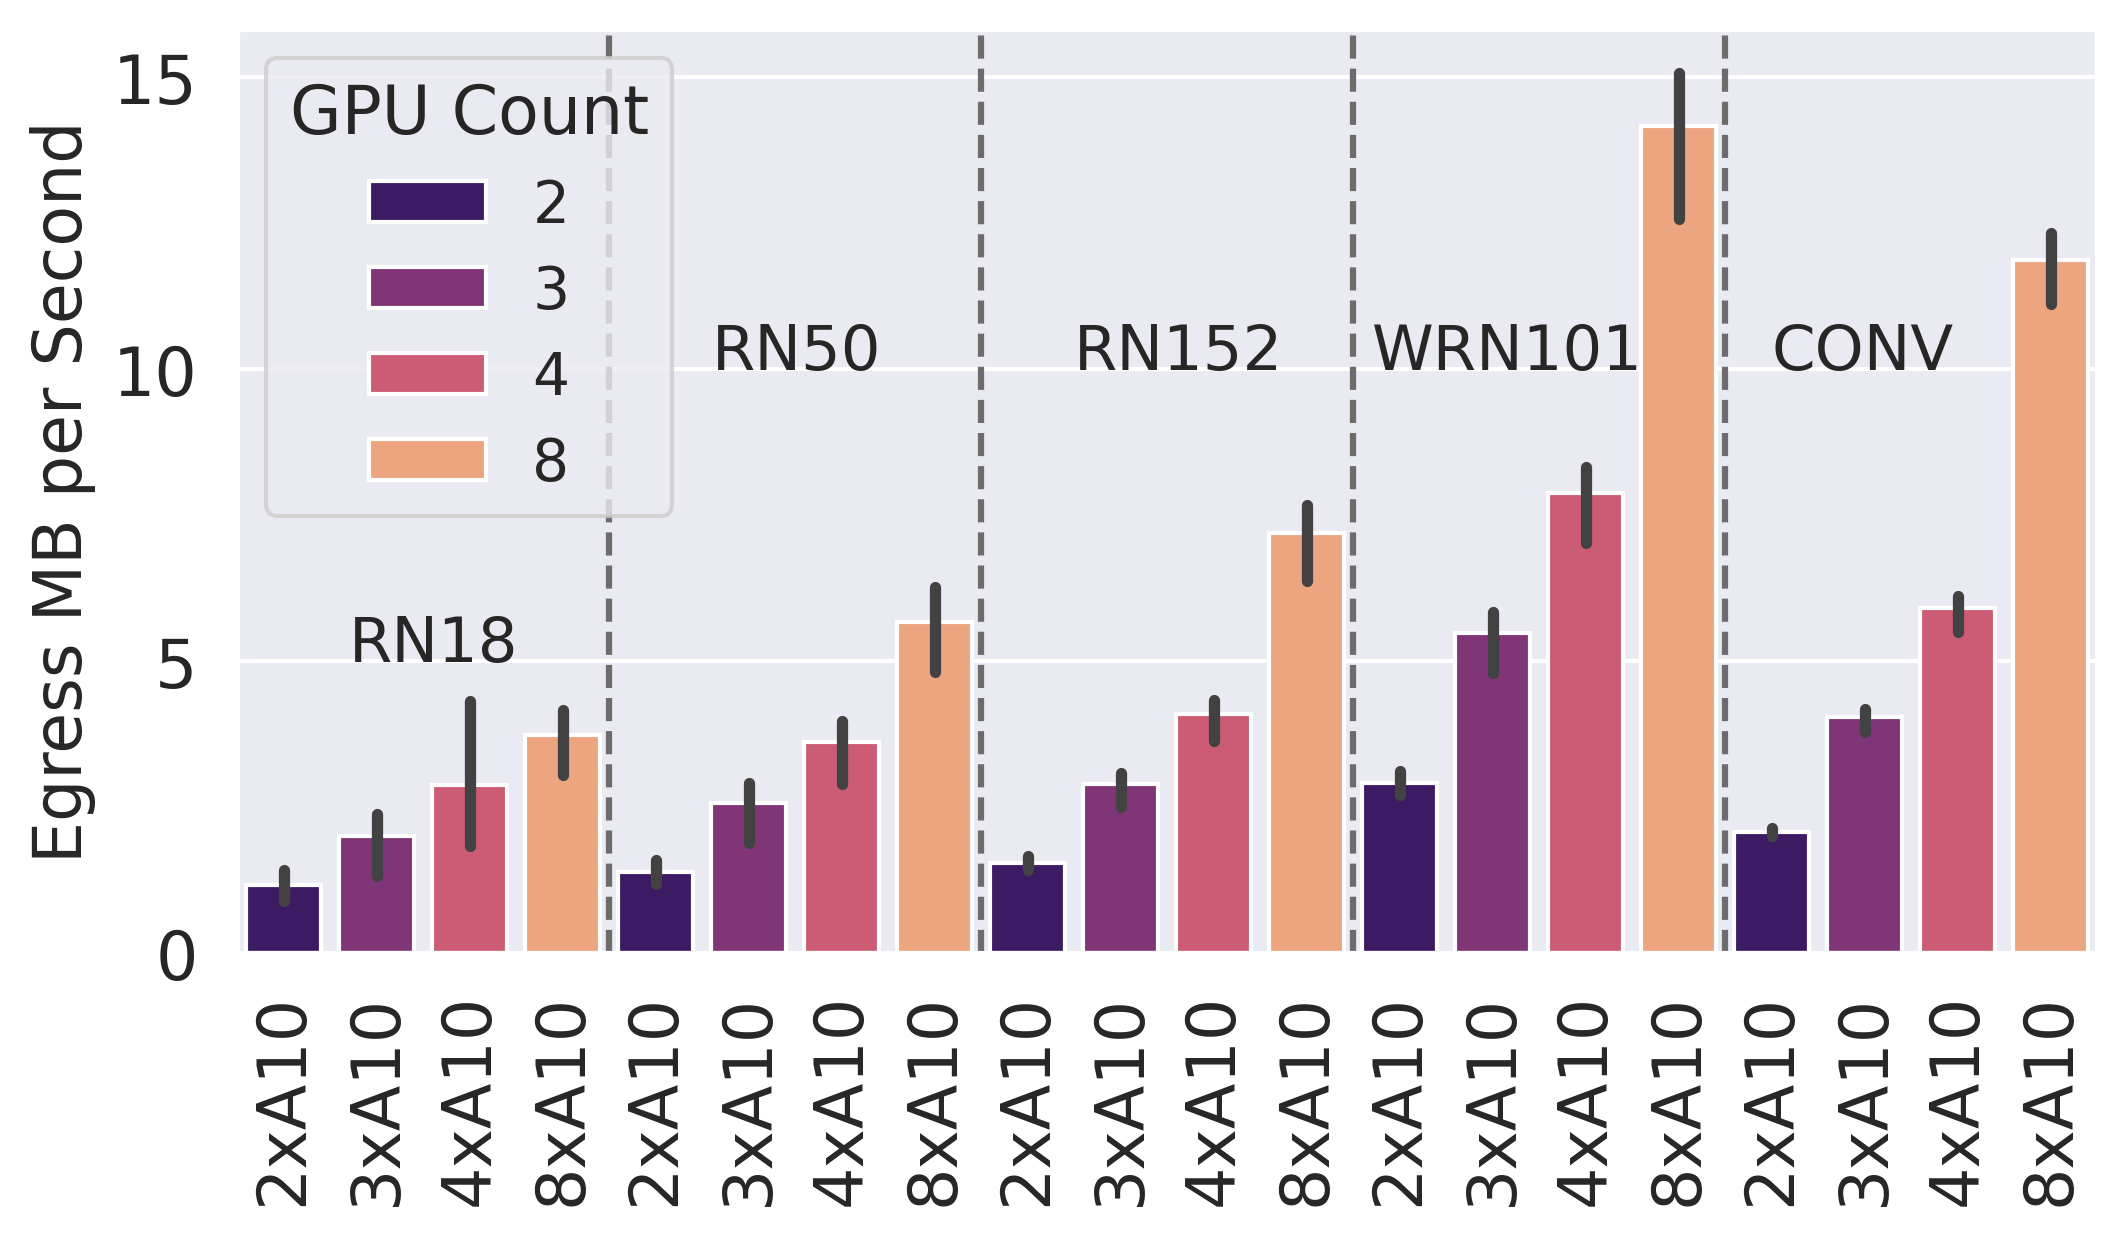

In [36]:
sns.set(palette=sns.color_palette("magma", 4))
plt.figure(figsize=(8,4))
set_fontsizes(16,16,16)
ax = sns.barplot(
    data=cv_baseline_bytes,
    x="name",
    y="sent_MB_per_sec",
    hue="gpu_count",
    dodge=False)
plt.xlabel("")
plt.ylabel("Egress MB per Second")
ax.axvline(3.5, color="#6c6c6c", linestyle="--")
ax.axvline(7.5, color="#6c6c6c", linestyle="--")
ax.axvline(11.5, color="#6c6c6c", linestyle="--")
ax.axvline(15.5, color="#6c6c6c", linestyle="--")
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ["".join(label.split(" ")[-1]) for label in labels]
ax.set_xticklabels(labels, rotation=90)
ax.text(0.7, 5, "RN18", fontsize=15)
ax.text(4.6, 10, "RN50", fontsize=15)
ax.text(8.5, 10, "RN152", fontsize=15)
ax.text(11.7,10, "WRN101", fontsize=15)
ax.text(16,  10, "CONV", fontsize=15)
plt.legend(title="GPU Count", fontsize=14, title_fontsize=16)
save_fig(f"cv_baseline_egress")

In [37]:
rBse_2xA10_32768_df = get_sent_bytes(run_name="hivemind-303", val_dict={ "name":"RBse 2xA10", "gpu_count": 2 })
rLrg_2xA10_32768_df = get_sent_bytes(run_name="hivemind-304", val_dict={ "name":"RLrg 2xA10", "gpu_count": 2 })
rXLM_2xA10_32768_df = get_sent_bytes(run_name="hivemind-305", val_dict={ "name":"RXLM 2xA10", "gpu_count": 2 })
rBse_3xA10_32768_df = get_sent_bytes(run_name="hivemind-311", val_dict={ "name":"RBse 3xA10", "gpu_count": 3 })
rLrg_3xA10_32768_df = get_sent_bytes(run_name="hivemind-312", val_dict={ "name":"RLrg 3xA10", "gpu_count": 3 })
rXLM_3xA10_32768_df = get_sent_bytes(run_name="hivemind-313", val_dict={ "name":"RXLM 3xA10", "gpu_count": 3 })
rBse_4xA10_32768_df = get_sent_bytes(run_name="hivemind-320", val_dict={ "name":"RBse 4xA10", "gpu_count": 4 })
rLrg_4xA10_32768_df = get_sent_bytes(run_name="hivemind-321", val_dict={ "name":"RLrg 4xA10", "gpu_count": 4 })
rXLM_4xA10_32768_df = get_sent_bytes(run_name="hivemind-322", val_dict={ "name":"RXLM 4xA10", "gpu_count": 4 })
rBse_8xA10_32768_df = get_sent_bytes(run_name="hivemind-331", val_dict={ "name":"RBse 8xA10", "gpu_count": 8 })
rLrg_8xA10_32768_df = get_sent_bytes(run_name="hivemind-332", val_dict={ "name":"RLrg 8xA10", "gpu_count": 8 })
rXLM_8xA10_32768_df = get_sent_bytes(run_name="hivemind-333", val_dict={ "name":"RXLM 8xA10", "gpu_count": 8 })

nlp_baseline_bytes = pd.concat(objs=[
    rBse_2xA10_32768_df,
    rBse_3xA10_32768_df,
    rBse_4xA10_32768_df,
    rBse_8xA10_32768_df,
    rLrg_2xA10_32768_df,
    rLrg_3xA10_32768_df,
    rLrg_4xA10_32768_df,
    rLrg_8xA10_32768_df,
    rXLM_2xA10_32768_df,
    rXLM_3xA10_32768_df,
    rXLM_4xA10_32768_df,
    rXLM_8xA10_32768_df,
])
nlp_baseline_bytes = nlp_baseline_bytes.reset_index(drop=True)
nlp_baseline_bytes["sent_MB_per_sec"] = nlp_baseline_bytes["data_sent_GB"] * 1000 / nlp_baseline_bytes["runtime_s"]

> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.


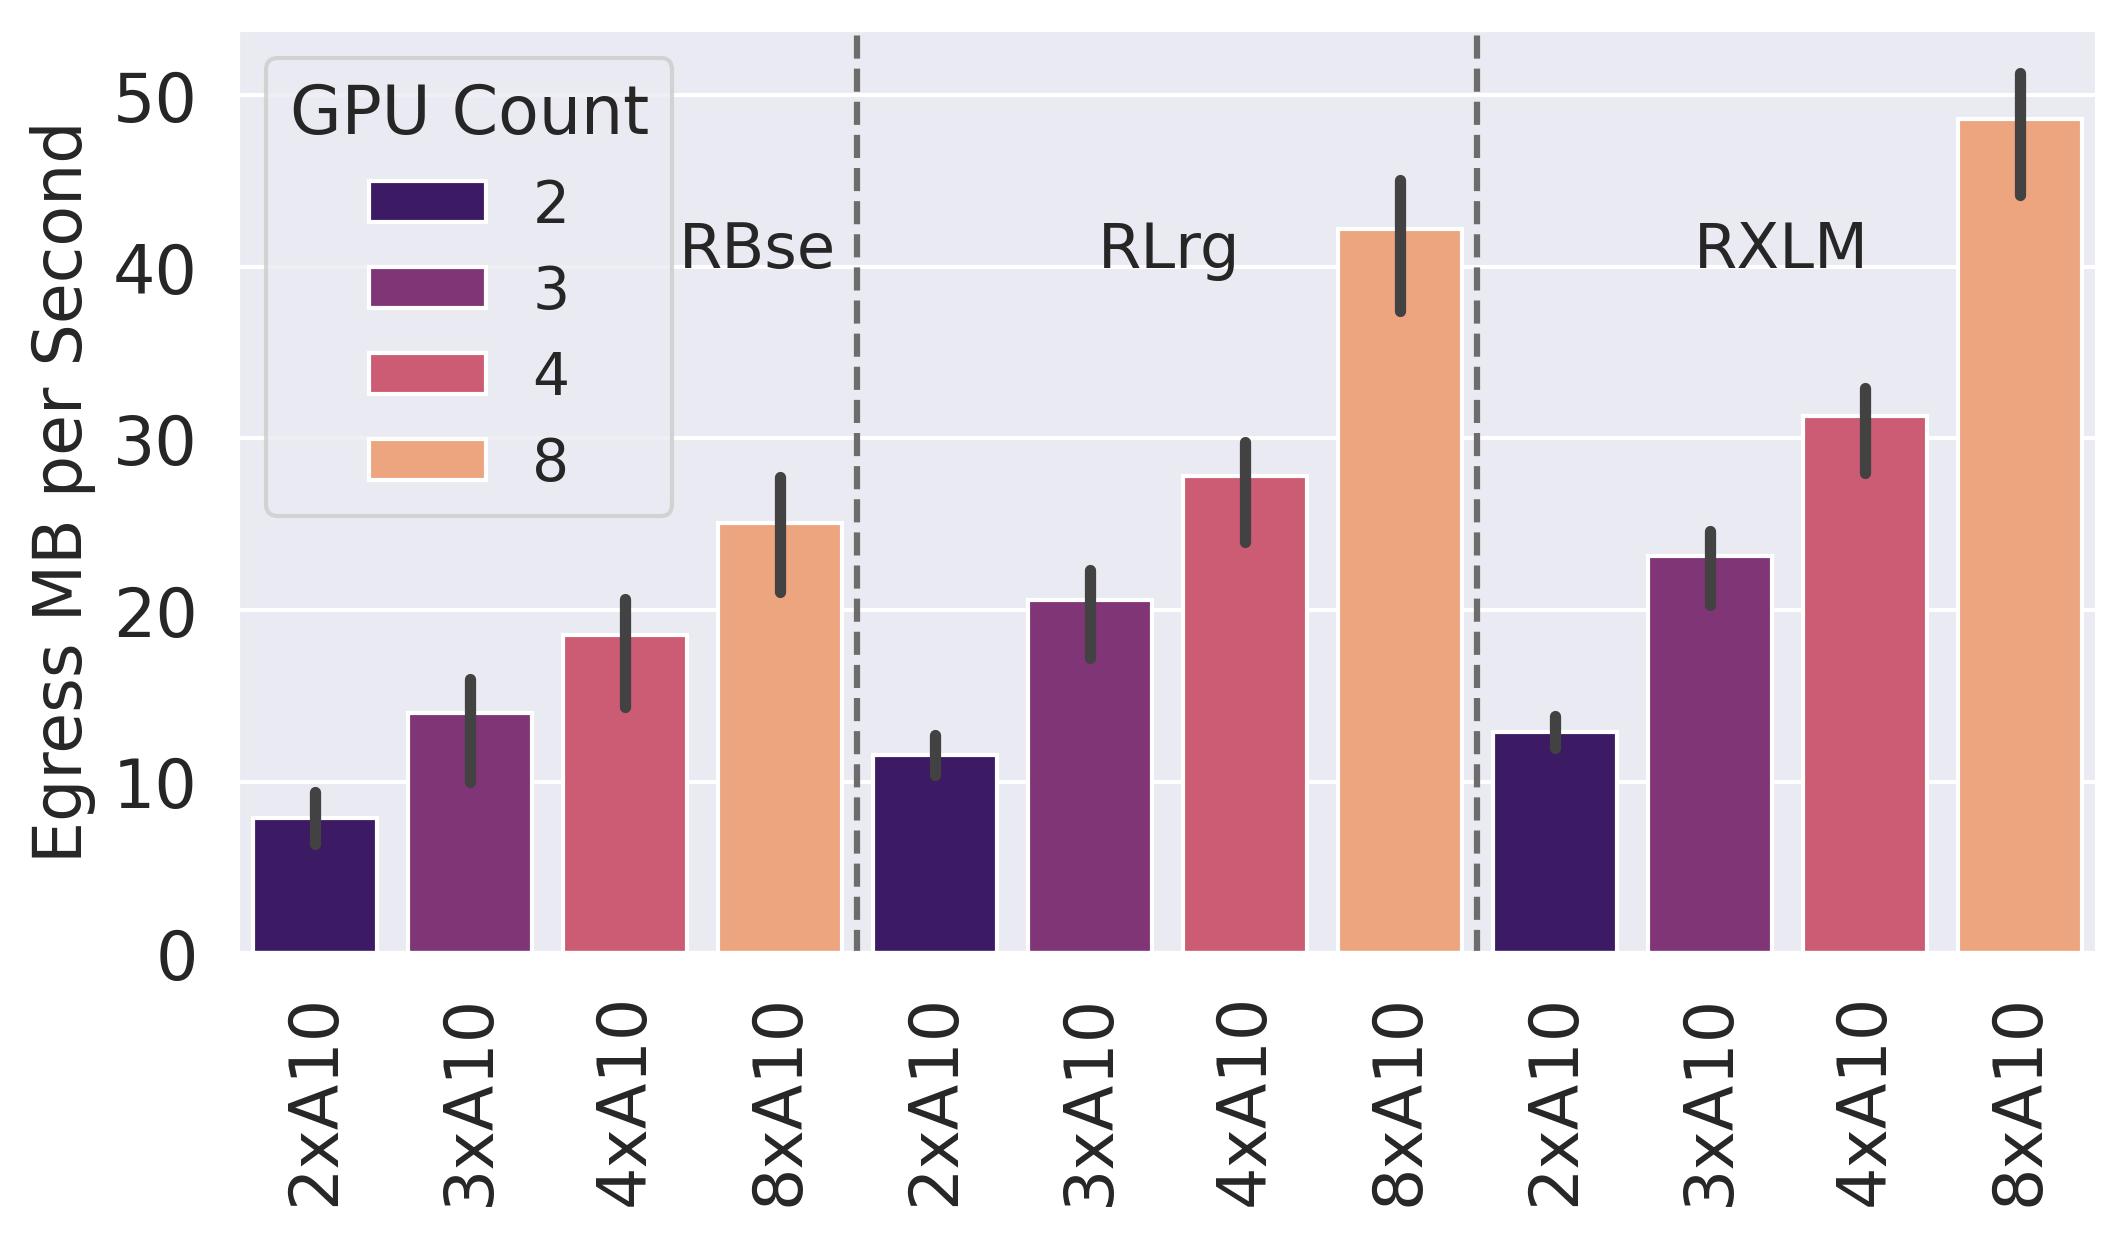

In [42]:
sns.set(palette=sns.color_palette("magma", 4))
plt.figure(figsize=(8,4))
set_fontsizes(16,16,16)
ax = sns.barplot(
    data=nlp_baseline_bytes,
    x="name",
    y="sent_MB_per_sec",
    hue="gpu_count",
    dodge=False)
plt.xlabel("")
plt.ylabel("Egress MB per Second")
ax.axvline(3.5, color="#6c6c6c", linestyle="--")
ax.axvline(7.5, color="#6c6c6c", linestyle="--")
ax.text(2.35, 40, "RBse", fontsize=15)
ax.text(5.05, 40, "RLrg", fontsize=15)
ax.text(8.9, 40, "RXLM", fontsize=15)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ["".join(label.split(" ")[-1]) for label in labels]
ax.set_xticklabels(labels, rotation=90)
plt.legend(title="GPU Count", loc="upper left", fontsize=14, title_fontsize=16)
save_fig(f"nlp_baseline_egress")

# Multi-threaded TCP over Continents

In [35]:
base_path = f"{NETWORK_PATH}/experiment-set-3/multi-threaded"

def get_iperf_df(filename, threads):
    df = pd.read_csv(base_path + "/" + filename)
    df["threads"] = threads

    def transform_row(r):
        r.bandwidth = r.bandwidth if r.bandwidth_metric == "Gbits/sec" else r.bandwidth / 1000
        r.bandwidth_metric = "Gbits/sec"
        r.target_hostname = "US" if r.target_hostname == "gc-t4-1-us" else "EU"
        return r

    return df.apply(transform_row, axis=1)
    
    

rtx8000_to_eu_1thread = get_iperf_df(filename="iperf-profile-vm-gpu-2-eu-1thread.csv", threads=1)
rtx8000_to_eu_5thread = get_iperf_df(filename="iperf-profile-vm-gpu-2-eu-5thread.csv", threads=5)
rtx8000_to_eu_10thread = get_iperf_df(filename="iperf-profile-vm-gpu-2-eu-10thread.csv", threads=10)
rtx8000_to_eu_20thread = get_iperf_df(filename="iperf-profile-vm-gpu-2-eu-20thread.csv", threads=20)
rtx8000_to_eu_40thread = get_iperf_df(filename="iperf-profile-vm-gpu-2-eu-40thread.csv", threads=40)
rtx8000_to_eu_80thread = get_iperf_df(filename="iperf-profile-vm-gpu-2-eu-80thread.csv", threads=80)

rtx8000_to_us_1thread = get_iperf_df(filename="iperf-profile-vm-gpu-2-us-1thread.csv", threads=1)
rtx8000_to_us_5thread = get_iperf_df(filename="iperf-profile-vm-gpu-2-us-5thread.csv", threads=5)
rtx8000_to_us_10thread = get_iperf_df(filename="iperf-profile-vm-gpu-2-us-10thread.csv", threads=10)
rtx8000_to_us_20thread = get_iperf_df(filename="iperf-profile-vm-gpu-2-us-20thread.csv", threads=20)
rtx8000_to_us_40thread = get_iperf_df(filename="iperf-profile-vm-gpu-2-us-40thread.csv", threads=40)
rtx8000_to_us_80thread = get_iperf_df(filename="iperf-profile-vm-gpu-2-us-80thread.csv", threads=80)
rtx8000_to_eu_us_multithreaded_df = pd.concat(objs=[
    rtx8000_to_eu_1thread,
    rtx8000_to_eu_5thread,
    rtx8000_to_eu_10thread,
    rtx8000_to_eu_20thread,
    rtx8000_to_eu_40thread,
    rtx8000_to_eu_80thread,
    rtx8000_to_us_1thread,
    rtx8000_to_us_5thread,
    rtx8000_to_us_10thread,
    rtx8000_to_us_20thread,
    rtx8000_to_us_40thread,
    rtx8000_to_us_80thread
])

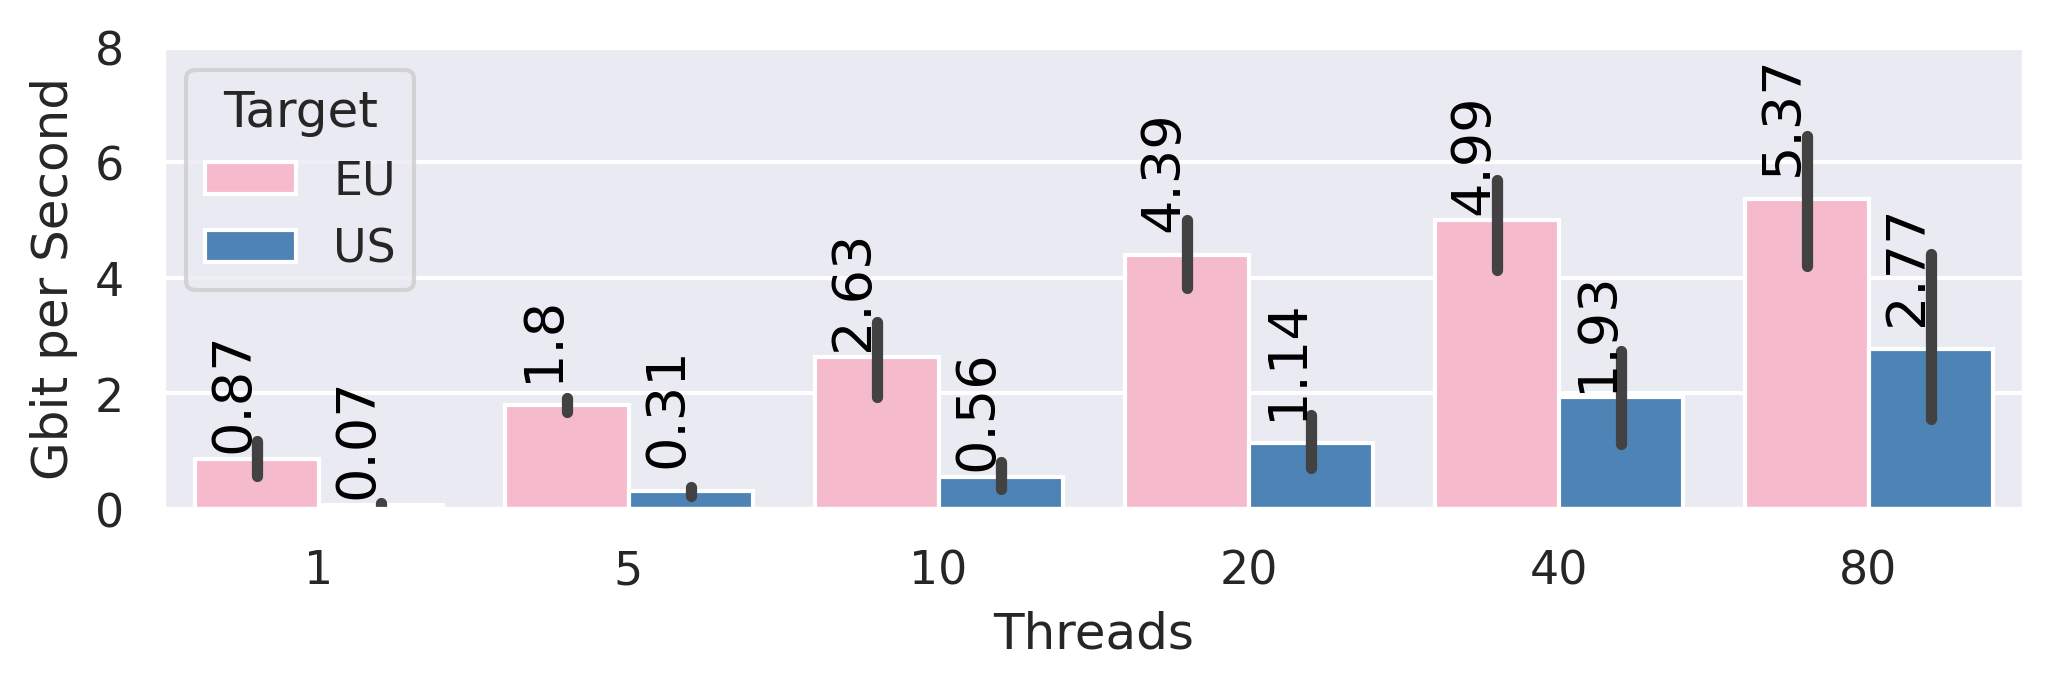

In [36]:
palette = ["#FFB1C9", "#3d85c6"]
sns.set(palette=sns.color_palette(palette, 2))

plt.figure(figsize=(8,2))
ax = sns.barplot(
    data=rtx8000_to_eu_us_multithreaded_df,
    x="threads",
    y="bandwidth",
    hue="target_hostname")
plt.ylabel("Gbit per Second")
plt.xlabel("Threads")
plt.legend(title="Target")
plt.ylim(0,8)
show_values_on_barplot(ax, height=0.3, rotation=90, decimals=2, fontsize=13)
save_fig("multi-threaded-iperf-eu-us")

In [37]:
eu_to_us_1thread = get_iperf_df(filename="eu-us/iperf-profile-gc-t4-2-eu-1thread.csv", threads=1)
eu_to_us_5thread = get_iperf_df(filename="eu-us/iperf-profile-gc-t4-2-eu-5thread.csv", threads=5)
eu_to_us_10thread = get_iperf_df(filename="eu-us/iperf-profile-gc-t4-2-eu-10thread.csv", threads=10)
eu_to_us_20thread = get_iperf_df(filename="eu-us/iperf-profile-gc-t4-2-eu-20thread.csv", threads=20)
eu_to_us_40thread = get_iperf_df(filename="eu-us/iperf-profile-gc-t4-2-eu-40thread.csv", threads=40)
eu_to_us_80thread = get_iperf_df(filename="eu-us/iperf-profile-gc-t4-2-eu-80thread.csv", threads=80)

eu_to_us_multithreaded_df = pd.concat(objs=[
    eu_to_us_1thread,  
    eu_to_us_5thread,  
    eu_to_us_10thread, 
    eu_to_us_20thread, 
    eu_to_us_40thread, 
    eu_to_us_80thread,
])

(0.0, 8.0)

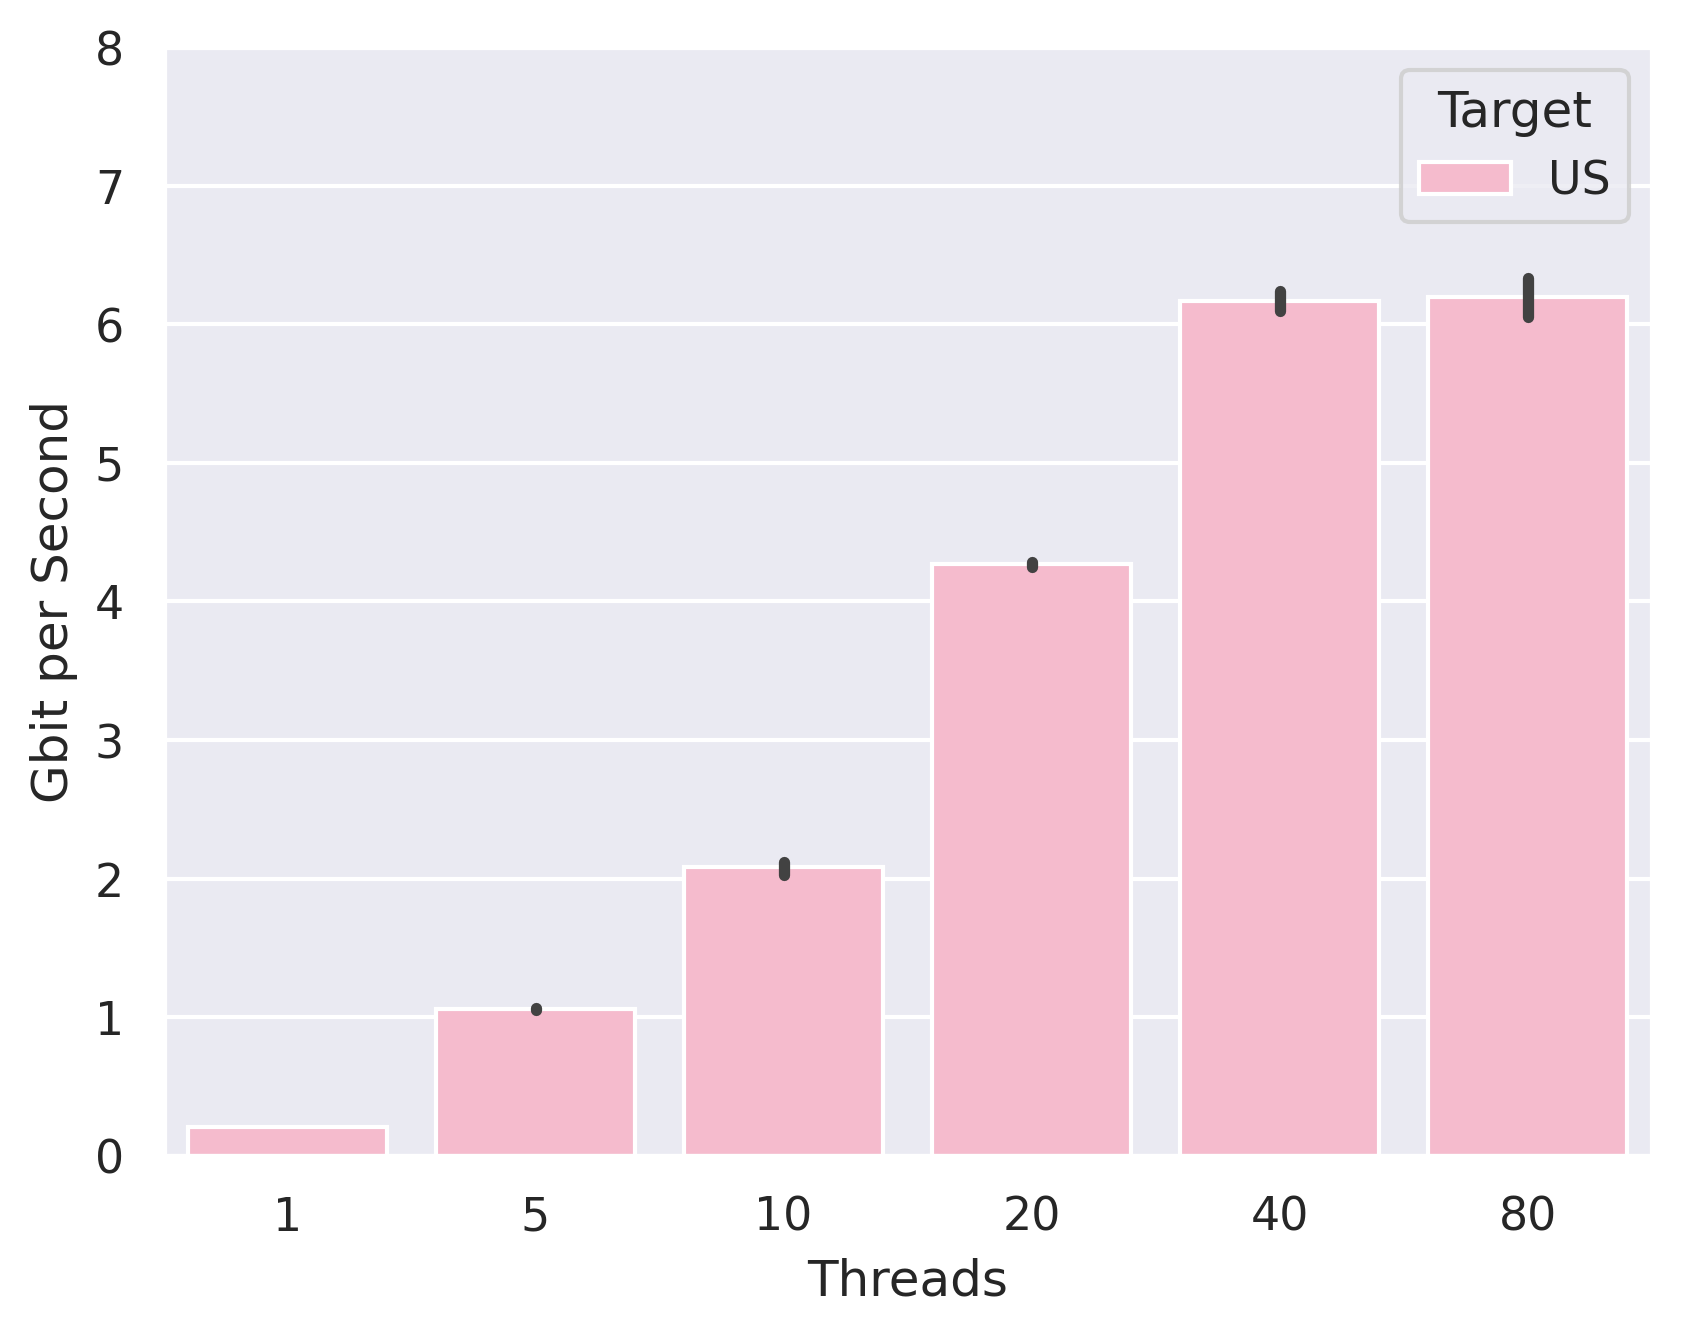

In [38]:
sns.barplot(
    data=eu_to_us_multithreaded_df,
    x="threads",
    y="bandwidth",
    hue="target_hostname")
plt.ylabel("Gbit per Second")
plt.xlabel("Threads")
plt.legend(title="Target")
plt.ylim(0,8)

In [39]:
def get_iperf_3_df(filename):
    base_path = f"{NETWORK_PATH}/experiment-set-3"
    df = pd.read_csv(base_path + "/" + filename)
    return df

e_a_network_df = get_iperf_3_df(filename="3-P.0/iperf-profile-rtx8000.csv")
e_b_network_df = get_iperf_3_df(filename="3-P.1/iperf-profile-rtx8000.csv")
e_c_network_df = get_iperf_3_df(filename="3-P.2/iperf-profile-rtx8000.csv")
f_a_network_df = get_iperf_3_df(filename="3-R.0/iperf-profile-8xv100.csv")
f_b_network_df = get_iperf_3_df(filename="3-R.1/iperf-profile-8xv100.csv")
f_c_network_df = get_iperf_3_df(filename="3-R.2/iperf-profile-8xv100.csv")

In [40]:
print("E-A Experiments (EU - EU)")
display(e_a_network_df.describe())
print("E-B Experiments (EU - US T4)")
display(e_b_network_df.describe())
print("E-C Experiments (EU - US A10)")
display(e_c_network_df.describe())

E-A Experiments (EU - EU)


,bandwidth,avg_ping_ms
count,5.000000,5.000000
mean,454.600000,16.731000
std,192.415696,0.189727
min,256.000000,16.516000
25%,380.000000,16.566000
50%,430.000000,16.765000
75%,433.000000,16.835000
max,774.000000,16.973000


E-B Experiments (EU - US T4)


,bandwidth,avg_ping_ms
count,5.000000,5.000000
mean,63.640000,150.803200
std,23.787665,0.284777
min,30.900000,150.590000
25%,53.600000,150.602000
50%,68.800000,150.737000
75%,69.100000,150.800000
max,95.800000,151.287000


E-C Experiments (EU - US A10)


,bandwidth,avg_ping_ms
count,5.000000,5.000000
mean,54.580000,159.054000
std,14.543624,0.067657
min,38.700000,158.983000
25%,39.400000,158.986000
50%,60.100000,159.062000
75%,65.500000,159.119000
max,69.200000,159.120000


In [41]:
print("F-A Experiments (EU - EU)")
display(f_a_network_df.describe())
print("F-B Experiments (EU - US T4)")
display(f_b_network_df.describe())
print("F-C Experiments (EU - US A10)")
display(f_c_network_df.describe())

F-A Experiments (EU - EU)


,bandwidth,avg_ping_ms
count,5.000000,5.000000
mean,550.200000,16.187200
std,148.380255,0.075794
min,358.000000,16.104000
25%,421.000000,16.156000
50%,657.000000,16.173000
75%,657.000000,16.194000
max,658.000000,16.309000


F-B Experiments (EU - US T4)


,bandwidth,avg_ping_ms
count,5.000000,5.000000
mean,77.840000,150.272000
std,10.192301,0.102291
min,66.900000,150.094000
25%,69.600000,150.282000
50%,76.800000,150.307000
75%,84.600000,150.338000
max,91.300000,150.339000


F-C Experiments (EU - US A10)


,bandwidth,avg_ping_ms
count,5.000000,5.000000
mean,69.900000,158.541800
std,12.335315,0.027317
min,52.000000,158.502000
25%,62.100000,158.526000
50%,76.600000,158.554000
75%,78.400000,158.558000
max,80.400000,158.569000


# Cost Per Throughput Ratio

In [43]:
# 8xV100
cv_8xV100_sps  = 413
nlp_8xV100_sps = 1811

spot_per_hour_8xV100 = 6.30
on_demand_per_hour_8xV100 = 14.60

print("8xV100")
print("  CV:")
print(f"    - spot sps/$/h: {round(cv_8xV100_sps / spot_per_hour_8xV100,2)}")
print(f"    - on-d sps/$/h: {round(cv_8xV100_sps / on_demand_per_hour_8xV100,2)}")
print("  NLP:")
print(f"    - spot sps/$/h: {round(nlp_8xV100_sps / spot_per_hour_8xV100,2)}")
print(f"    - on-d sps/$/h: {round(nlp_8xV100_sps / on_demand_per_hour_8xV100,2)}")

# 8xT4
cv_8xT4_sps = 262
nlp_8xT4_sps = 575

cv_spot_per_hour_8xT4 = 8*(0.180 + 0.029)
nlp_spot_per_hour_8xT4 = 8*(0.180 + 0.191)
cv_on_demand_per_hour_8xT4 = 8*(0.572 + 0.029)
nlp_on_demand_per_hour_8xT4 = 8*(0.572 + 0.191)

print("8xT4")
print("  CV:")
print(f"    - spot sps/$/h: {round(cv_8xT4_sps / cv_spot_per_hour_8xT4,2)}")
print(f"    - on-d sps/$/h: {round(cv_8xT4_sps / cv_on_demand_per_hour_8xT4,2)}")
print("  NLP:")
print(f"    - spot sps/$/h: {round(nlp_8xT4_sps / nlp_spot_per_hour_8xT4,2)}")
print(f"    - on-d sps/$/h: {round(nlp_8xT4_sps / nlp_on_demand_per_hour_8xT4,2)}")

# 8xA10
cv_8xA10_sps = 621
nlp_8xA10_sps = 1060
on_demand_per_hour_8xA10 = 8*0.60

print("8xA10")
print("  CV:")
print(f"    - on-d sps/$/h: {round(cv_8xA10_sps / on_demand_per_hour_8xA10,2)}")
print("  NLP:")
print(f"    - on-d sps/$/h: {round(nlp_8xA10_sps / on_demand_per_hour_8xA10,2)}")


8xV100
  CV:
    - spot sps/$/h: 65.56
    - on-d sps/$/h: 28.29
  NLP:
    - spot sps/$/h: 287.46
    - on-d sps/$/h: 124.04
8xT4
  CV:
    - spot sps/$/h: 156.7
    - on-d sps/$/h: 54.49
  NLP:
    - spot sps/$/h: 193.73
    - on-d sps/$/h: 94.2
8xA10
  CV:
    - on-d sps/$/h: 129.38
  NLP:
    - on-d sps/$/h: 220.83


In [44]:
sps_cost_dict = {
    "name": [],
    "domain": [], 
    "sps": [],
    "cost_per_hour": [],
    "cost_per_sps": [],
    "instance_type": []
}

def add_to_sps_cost_dict(name, domain, sps, cost_per_hour, cost_per_sps, instance_type):
    sps_cost_dict["name"].append(name)
    sps_cost_dict["domain"].append(domain)
    sps_cost_dict["sps"].append(sps)
    sps_cost_dict["cost_per_hour"].append(cost_per_hour)
    sps_cost_dict["cost_per_sps"].append(cost_per_sps * 1000 * 1000)
    sps_cost_dict["instance_type"].append(instance_type)

# 8xV100
cv_8xV100_sps  = 413
nlp_8xV100_sps = 1811
spot_per_hour_8xV100 = 6.30
on_demand_per_hour_8xV100 = 14.60

cv_spot_cost_per_sps_8xV100 = spot_per_hour_8xV100 / 60 / 60 / cv_8xV100_sps
nlp_spot_cost_per_sps_8xV100 = spot_per_hour_8xV100 / 60 / 60 / nlp_8xV100_sps
cv_on_demand_cost_per_sps_8xV100 = on_demand_per_hour_8xV100 / 60 / 60 / cv_8xV100_sps
nlp_on_demand_cost_per_sps_8xV100 = on_demand_per_hour_8xV100 / 60 / 60 / nlp_8xV100_sps

add_to_sps_cost_dict(name="DGX-2",instance_type="Spot", domain="CV", sps=cv_8xV100_sps,      cost_per_sps=cv_spot_cost_per_sps_8xV100,cost_per_hour=spot_per_hour_8xV100)
add_to_sps_cost_dict(name="DGX-2",instance_type="Spot", domain="NLP",sps=nlp_8xV100_sps,     cost_per_sps=nlp_spot_cost_per_sps_8xV100,cost_per_hour=spot_per_hour_8xV100)
add_to_sps_cost_dict(name="DGX-2",instance_type="On-Demand", domain="CV", sps=cv_8xV100_sps, cost_per_sps=cv_on_demand_cost_per_sps_8xV100,cost_per_hour=on_demand_per_hour_8xV100)
add_to_sps_cost_dict(name="DGX-2",instance_type="On-Demand", domain="NLP",sps=nlp_8xV100_sps,cost_per_sps=nlp_on_demand_cost_per_sps_8xV100,cost_per_hour=on_demand_per_hour_8xV100)

# 8xT4
cv_8xT4_sps = 262
nlp_8xT4_sps = 575
cv_spot_per_hour_8xT4 = 8*(0.180 + 0.029)
nlp_spot_per_hour_8xT4 = 8*(0.180 + 0.191)
cv_on_demand_per_hour_8xT4 = 8*(0.572 + 0.029)
nlp_on_demand_per_hour_8xT4 = 8*(0.572 + 0.191)

cv_spot_cost_per_sps_8xT4 = cv_spot_per_hour_8xT4 / 60 / 60 / cv_8xT4_sps
nlp_spot_cost_per_sps_8xT4 = nlp_spot_per_hour_8xT4 / 60 / 60 / nlp_8xT4_sps
cv_on_demand_cost_per_sps_8xT4 = cv_on_demand_per_hour_8xT4 / 60 / 60 / cv_8xT4_sps
nlp_on_demand_cost_per_sps_8xT4 = nlp_on_demand_per_hour_8xT4 / 60 / 60 / nlp_8xT4_sps

add_to_sps_cost_dict(name="8xT4",instance_type="Spot",domain="CV", sps=cv_8xT4_sps,      cost_per_sps=cv_spot_cost_per_sps_8xT4,cost_per_hour=cv_spot_per_hour_8xT4)
add_to_sps_cost_dict(name="8xT4",instance_type="Spot",domain="NLP",sps=nlp_8xT4_sps,     cost_per_sps=nlp_spot_cost_per_sps_8xT4,cost_per_hour=nlp_spot_per_hour_8xT4)
add_to_sps_cost_dict(name="8xT4",instance_type="On-Demand",domain="CV", sps=cv_8xT4_sps, cost_per_sps=cv_on_demand_cost_per_sps_8xT4,cost_per_hour=cv_on_demand_per_hour_8xT4)
add_to_sps_cost_dict(name="8xT4",instance_type="On-Demand",domain="NLP",sps=nlp_8xT4_sps,cost_per_sps=nlp_on_demand_cost_per_sps_8xT4,cost_per_hour=nlp_on_demand_per_hour_8xT4)

# 1xT4
cv_1x_T4_sps = 80.8
nlp_1x_T4_sps = 208.8
spot_per_hour_1xT4 = 0.180
on_demand_per_hour_1xT4 = 0.572

cv_spot_cost_per_sps_1xT4 = spot_per_hour_1xT4 / 60 / 60 / cv_1x_T4_sps
nlp_spot_cost_per_sps_1xT4 = spot_per_hour_1xT4 / 60 / 60 / nlp_1x_T4_sps
cv_on_demand_cost_per_sps_1xT4 = on_demand_per_hour_1xT4 / 60 / 60 / cv_1x_T4_sps
nlp_on_demand_cost_per_sps_1xT4 = on_demand_per_hour_1xT4 / 60 / 60 / nlp_1x_T4_sps

add_to_sps_cost_dict(name="1xT4",instance_type="Spot",domain="CV", sps=cv_1x_T4_sps,  cost_per_sps=cv_spot_cost_per_sps_1xT4, cost_per_hour=spot_per_hour_1xT4)
add_to_sps_cost_dict(name="1xT4",instance_type="Spot",domain="NLP",sps=nlp_1x_T4_sps, cost_per_sps=nlp_spot_cost_per_sps_1xT4, cost_per_hour=spot_per_hour_1xT4)
add_to_sps_cost_dict(name="1xT4",instance_type="On-Demand",domain="CV", sps=cv_1x_T4_sps,  cost_per_sps=cv_on_demand_cost_per_sps_1xT4, cost_per_hour=on_demand_per_hour_1xT4)
add_to_sps_cost_dict(name="1xT4",instance_type="On-Demand",domain="NLP",sps=nlp_1x_T4_sps, cost_per_sps=nlp_on_demand_cost_per_sps_1xT4, cost_per_hour=on_demand_per_hour_1xT4)

# 8xA10
cv_8xA10_sps = 621
nlp_8xA10_sps = 1060
on_demand_per_hour_8xA10 = 8*0.60

cv_on_demand_cost_per_sps_8xA10 = on_demand_per_hour_8xA10 / 60 / 60 / cv_8xA10_sps
nlp_on_demand_cost_per_sps_8xA10 = on_demand_per_hour_8xA10 / 60 / 60 / nlp_8xA10_sps

add_to_sps_cost_dict(name="8xA10",instance_type="On-Demand",domain="CV", sps=cv_8xA10_sps, cost_per_sps=cv_on_demand_cost_per_sps_8xA10, cost_per_hour=on_demand_per_hour_8xA10)
add_to_sps_cost_dict(name="8xA10",instance_type="On-Demand",domain="NLP",sps=nlp_8xA10_sps,cost_per_sps=nlp_on_demand_cost_per_sps_8xA10, cost_per_hour=on_demand_per_hour_8xA10)

# 1xA10
cv_1xA10_sps = 185.7
nlp_1xA10_sps = 463.6
on_demand_per_hour_1xA10 = 0.60

cv_on_demand_cost_per_sps_1xA10 = on_demand_per_hour_1xA10 / 60 / 60 / cv_1xA10_sps
nlp_on_demand_cost_per_sps_1xA10 = on_demand_per_hour_1xA10 / 60 / 60 / nlp_1xA10_sps


add_to_sps_cost_dict(name="1xA10",instance_type="On-Demand",domain="CV", sps=cv_1xA10_sps, cost_per_sps=cv_on_demand_cost_per_sps_1xA10, cost_per_hour=on_demand_per_hour_1xA10)
add_to_sps_cost_dict(name="1xA10",instance_type="On-Demand",domain="NLP",sps=nlp_1xA10_sps,cost_per_sps=nlp_on_demand_cost_per_sps_1xA10, cost_per_hour=on_demand_per_hour_1xA10)

sps_cost_df = pd.DataFrame(sps_cost_dict)
sps_cost_df

,name,domain,sps,cost_per_hour,cost_per_sps,instance_type
0,DGX-2,CV,413.0,6.300,4.237288,Spot
1,DGX-2,NLP,1811.0,6.300,0.966317,Spot
2,DGX-2,CV,413.0,14.600,9.819747,On-Demand
3,DGX-2,NLP,1811.0,14.600,2.239401,On-Demand
4,8xT4,CV,262.0,1.672,1.772689,Spot
5,8xT4,NLP,575.0,2.968,1.433816,Spot
6,8xT4,CV,262.0,4.808,5.097540,On-Demand
7,8xT4,NLP,575.0,6.104,2.948792,On-Demand
8,1xT4,CV,80.8,0.180,0.618812,Spot
9,1xT4,NLP,208.8,0.180,0.239464,Spot


In [45]:
print(f"NLP 8xV100 vs 8xA10 sps: {round((1 - 1060.0 / 1811.0) * 100,2)}% slower")
print(f"NLP 8xV100 vs 8xA10 cost: {round((1.257862 / 0.966317) * 100,2)}% more expensive")

print(f"CV 8xV100 vs 8xA10 sps:  {round((621.0 / 413.0) * 100,2)}% faster")
print(f"CV 8xV100 vs 8xA10 cost: {round((1 - 2.147075 / 4.237288) * 100,2)}% less expensive")
print(f"CV 8xV100 vs 8xT4 sps:   {round((1 - 262.0 / 413.0) * 100,2)}% slower")
print(f"CV 8xV100 vs 8xT4 cost:  {round((1 - 1.772689 / 4.237288) * 100,2)}% less expensive")


NLP 8xV100 vs 8xA10 sps: 41.47% slower
NLP 8xV100 vs 8xA10 cost: 130.17% more expensive
CV 8xV100 vs 8xA10 sps:  150.36% faster
CV 8xV100 vs 8xA10 cost: 49.33% less expensive
CV 8xV100 vs 8xT4 sps:   36.56% slower
CV 8xV100 vs 8xT4 cost:  58.16% less expensive


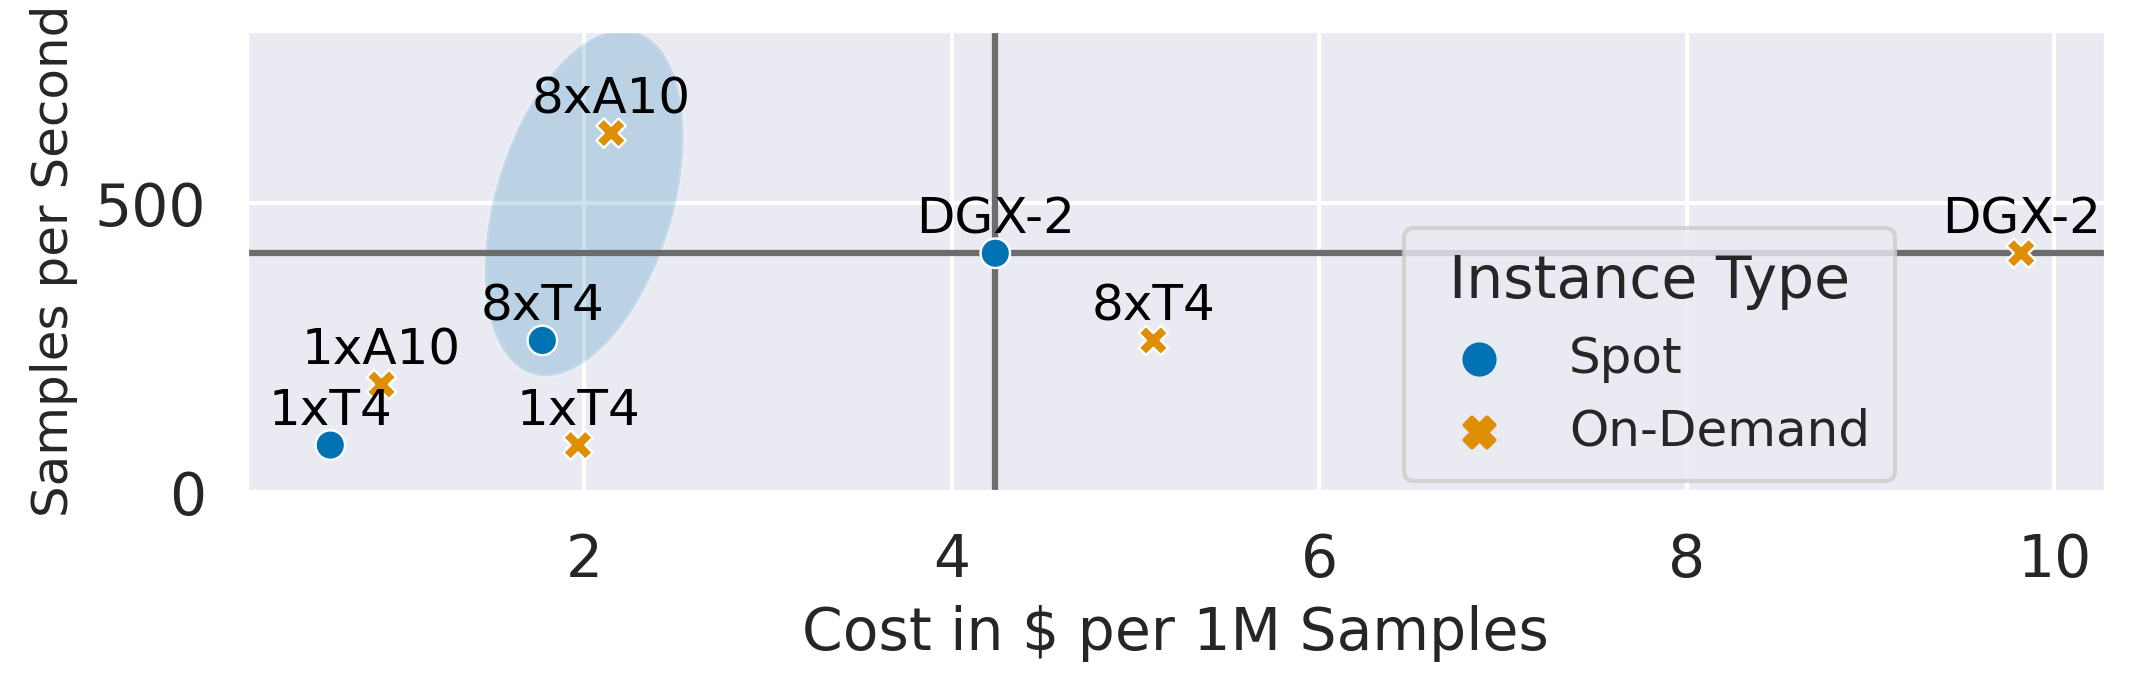

In [53]:
from matplotlib.patches import Ellipse

sns.set(palette=default_palette)
set_fontsizes(14,14,14)

fig, ax = plt.subplots(figsize=(8, 2))

temp_df = sps_cost_df.query(f"domain=='CV'")
temp_df = temp_df.reset_index()
#temp_df = temp_df.
ax = sns.scatterplot(
    data=temp_df,
    x="cost_per_sps",
    y="sps",
    color="0.3", s=50, hue="instance_type", style="instance_type", zorder=2)

plt.ylabel("Samples per Second", fontsize=12)
plt.xlabel("Cost in $ per 1M Samples")

for entry in range(0, temp_df.shape[0]):
    xoffset = 0
    yoffset = 35

    text = temp_df["name"][entry]
    alignment = "center"
    ax.text(
        x=temp_df["cost_per_sps"][entry] + xoffset,
        y=temp_df["sps"][entry] + yoffset,
        s=text,
        horizontalalignment=alignment,
        size=12,
        color='black',
        weight='normal',)

plt.legend(title='Instance Type', loc="lower right", bbox_to_anchor=(0.9, -0.03),
           markerscale=1.2, scatterpoints=1, fontsize=12, title_fontsize=14, borderpad=0.5)
plt.ylim(0, 800)

cost_per_sps_8xT4 = temp_df.query("name=='8xT4' and instance_type=='Spot'")["cost_per_sps"].item()
cost_per_sps_8xV100 = temp_df.query("name=='DGX-2' and instance_type=='Spot'")["cost_per_sps"].item()
cost_per_sps_8xA10 = temp_df.query("name=='8xA10' and instance_type=='On-Demand'")["cost_per_sps"].item()


t4_cheaper_than_v100 = round((1 - (cost_per_sps_8xT4 / cost_per_sps_8xV100)) * 100,1) 
a10_cheaper_than_v100 = round((1 - (cost_per_sps_8xA10 / cost_per_sps_8xV100)) * 100,1) 

#ax.annotate(f'{t4_cheaper_than_v100}% cheaper than DGX-2', xy=(1.9, 262.0), xytext=(3, 50),
#            arrowprops=dict(facecolor='#313030', shrink=0.05))
#ax.annotate(f'{a10_cheaper_than_v100}% cheaper than DGX-2', xy=(2.2, 621), xytext=(3, 600),
#            arrowprops=dict(facecolor='#313030', shrink=0.05))

ellipse = Ellipse((2, 500), 1, 600, angle=-0.04, alpha=0.2)
ax.add_artist(ellipse)
#ellipse = Ellipse((5.1, 300), 0.8 , 300, angle=0, alpha=0.2)
#ax.add_artist(ellipse)

ax.axvline(4.237, color="#6c6c6c", linestyle="-", zorder=1)
ax.axhline(413, color="#6c6c6c", linestyle="-", zorder=1)



save_fig("cv_cost_per_sps_comparison")

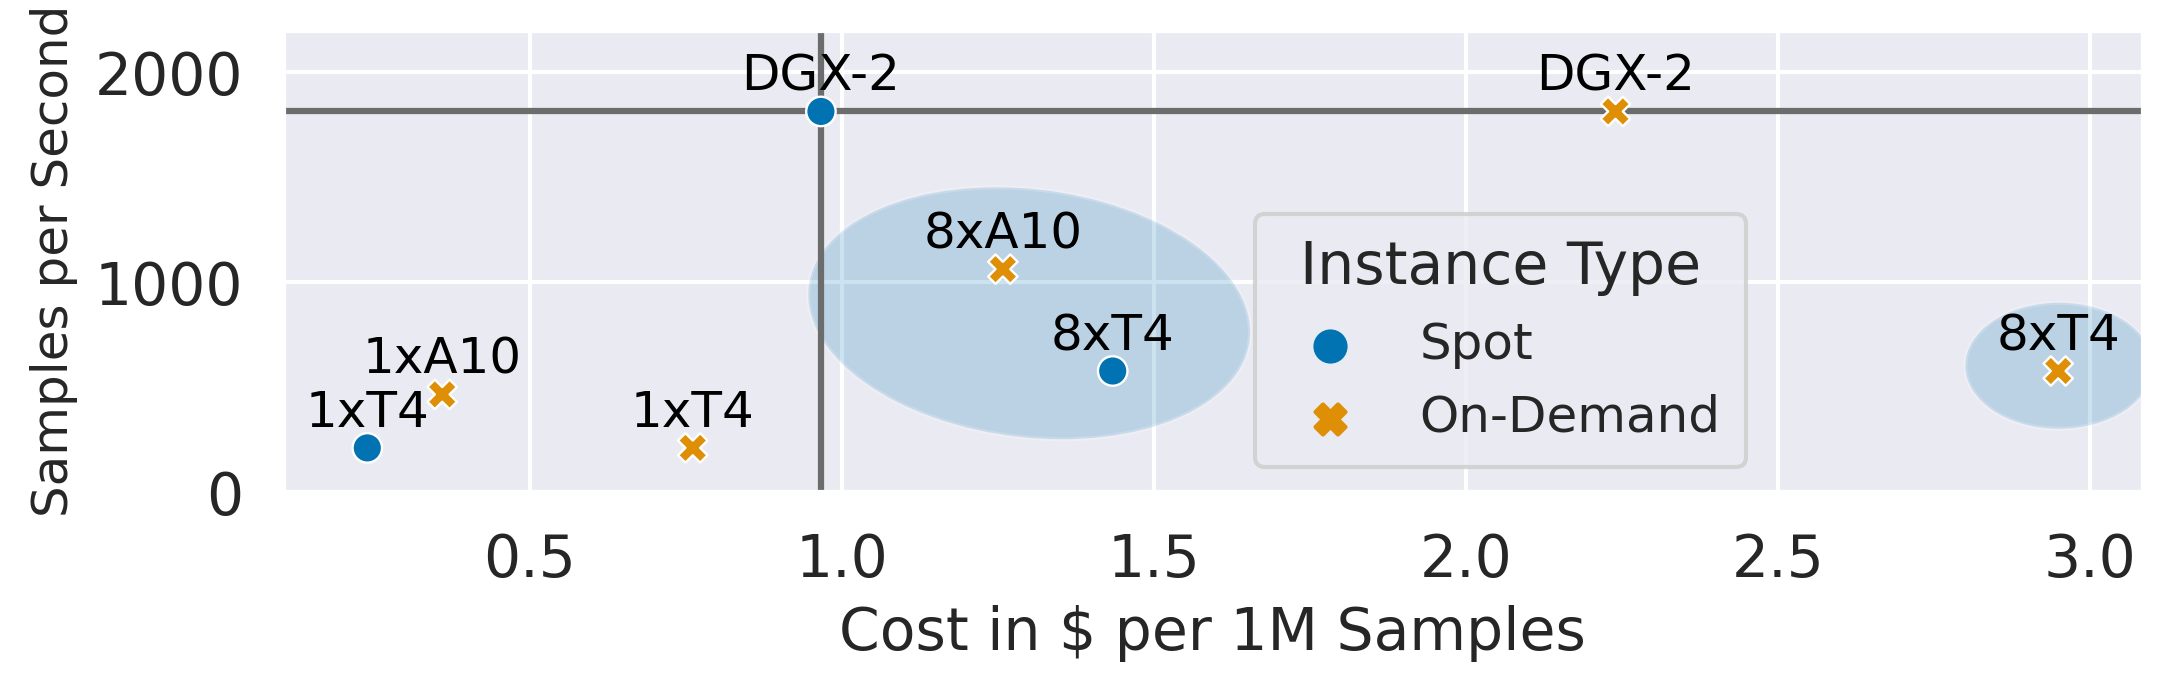

In [54]:
fig, ax = plt.subplots(figsize=(8, 2))
sns.set(palette=default_palette)
set_fontsizes(14,14,14)

temp_df = sps_cost_df.query(f"domain=='NLP'")
temp_df = temp_df.reset_index()
#temp_df = temp_df.
ax = sns.scatterplot(
    data=temp_df,
    x="cost_per_sps",
    y="sps",
    color="0.3", s=50, hue="instance_type", style="instance_type", zorder=2)

plt.ylabel("Samples per Second", fontsize=12)
plt.xlabel("Cost in $ per 1M Samples")

for entry in range(0, temp_df.shape[0]):
    xoffset = 0
    yoffset = 100

    text = temp_df["name"][entry]
    alignment = "center"
    ax.text(
        x=temp_df["cost_per_sps"][entry] + xoffset,
        y=temp_df["sps"][entry] + yoffset,
        s=text,
        horizontalalignment=alignment,
        size=12,
        color='black',
        weight='normal',)
    
from matplotlib.patches import Ellipse

ellipse = Ellipse((1.3, 850), 0.7 , 1200, angle=0.005, alpha=0.2)
ax.add_artist(ellipse)
ellipse = Ellipse((2.95, 600), 0.3 , 600, angle=0, alpha=0.2)
ax.add_artist(ellipse)

ax.axvline(0.966, color="#6c6c6c", linestyle="-", zorder=1)
ax.axhline(1811, color="#6c6c6c", linestyle="-", zorder=1)
    
plt.legend(title='Instance Type', markerscale=1.2, loc="lower right", bbox_to_anchor=(0.8, 0),
           scatterpoints=1, fontsize=12, title_fontsize=14, borderpad=0.5)
plt.ylim(0, 2200)
save_fig("nlp_cost_per_sps_comparison")

## 99. Whisper

In [7]:
whisper_small_1024_df = get_sent_bytes(run_name="hivemind-382", val_dict={ "name":"WhisperSmall 8xT4 1024", "gpu_count": 8 })
whisper_small_1024_df

> Found 8 runs with the infix 'bee'.


,data_sent_GB,data_recv_GB,dataloading_recv_acc_GB,runtime_s,hostname,name,gpu_count
0,4.195116,5.151133,0.983637,224,gc-t4-7,WhisperSmall 8xT4 1024,8
1,4.208755,5.155688,0.983750,225,gc-t4-8,WhisperSmall 8xT4 1024,8
2,4.217838,5.160192,0.977128,232,gc-t4-5,WhisperSmall 8xT4 1024,8
3,4.207457,5.156558,0.985194,232,gc-t4-4,WhisperSmall 8xT4 1024,8
4,4.194984,5.173732,0.975540,232,gc-t4-2,WhisperSmall 8xT4 1024,8
5,4.196983,5.147754,0.978250,232,gc-t4-3,WhisperSmall 8xT4 1024,8
6,4.210778,5.155262,0.974388,232,gc-t4-6,WhisperSmall 8xT4 1024,8
7,4.215198,5.160462,0.976362,326,gc-t4-1,WhisperSmall 8xT4 1024,8


In [15]:
avg_gb_s = (whisper_small_1024_df["data_sent_GB"] / whisper_small_1024_df["runtime_s"]).mean()
print(f"T4x8 Avg GB/s: {avg_gb_s}")
print(f"T4x8 Avg Bandwidth cost in $/s: {avg_gb_s * 0.01}") # 0.01$/GB per GC intra
print(f"T4x8 Avg Bandwidth cost in $/h: {avg_gb_s * 0.01 * 60 * 60}")

T4x8 Avg GB/s: 0.01762524123712828
T4x8 Avg Bandwidth cost in $/s: 0.0001762524123712828
T4x8 Avg Bandwidth cost in $/h: 0.634508684536618


WOW, GC changed the intra-zone bandwidth costs again? -.-


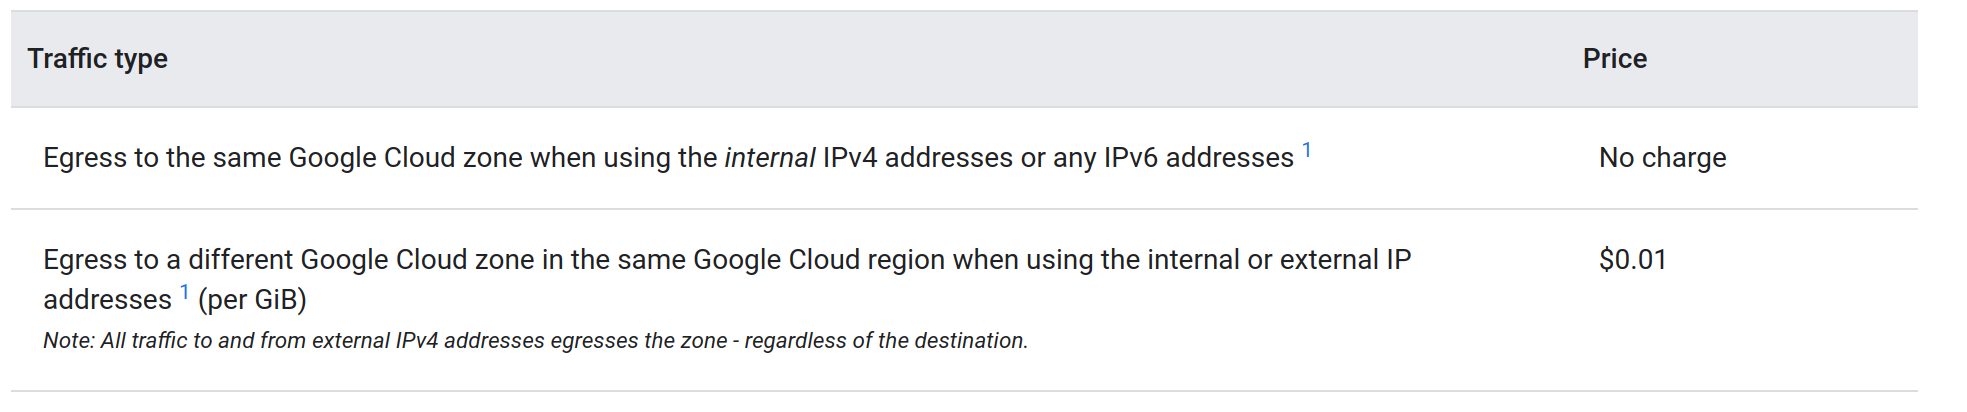